**Projet 7 - Implémentez un modèle de scoring**

*Auteur : Berechet Stefan, Formation OpenClassrooms Data Scientist 9 mois du 13 novembre 2020 au 13 août 2021* 


**Objectif du Projet :**

    Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
    
    Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.


In [1]:
# importation bibliothéques utiles
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
import gc
import warnings
import time
warnings.filterwarnings("ignore")

# **Partie 1 - Analyse Exploratoire**

Utilisation et inspiration du kernenl kaggle https://github.com/oskird/Kaggle-Home-Credit-Default-Risk-Solution


## **Chargement des données**

In [2]:
application_train = pd.read_csv('application_train.csv')
application_test= pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')

**Lien entre les différentes tables :**

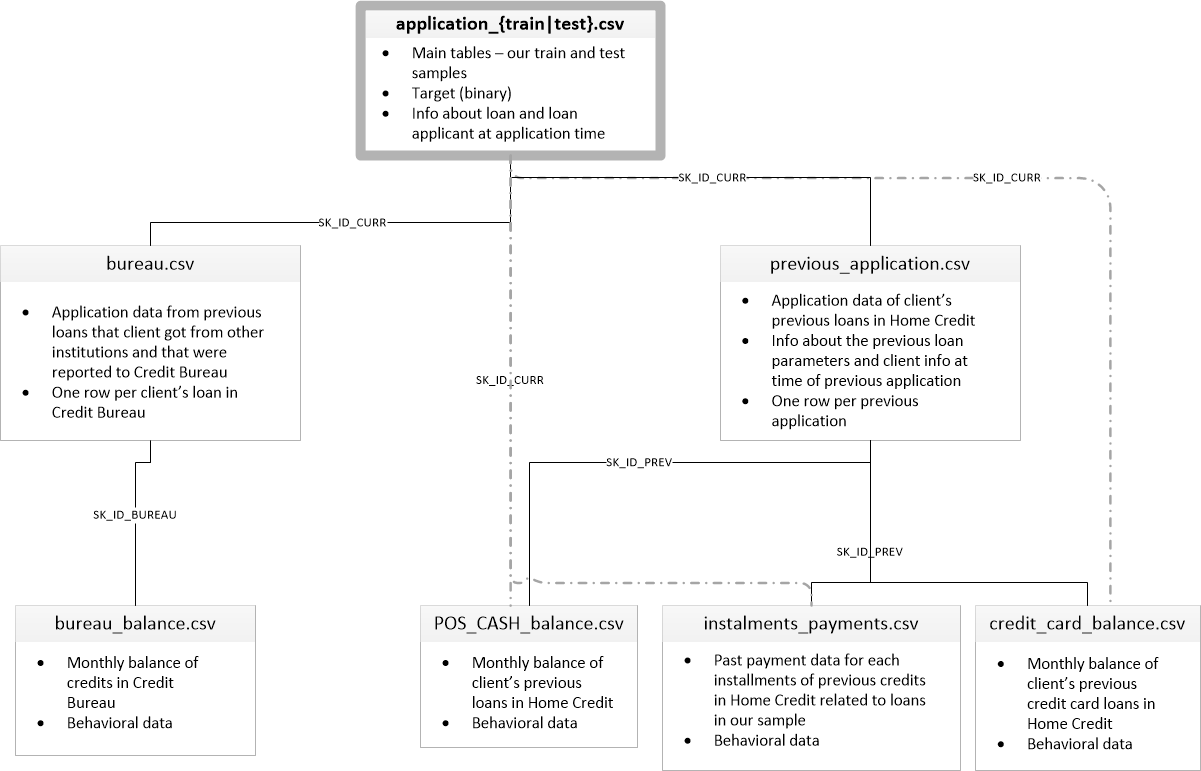

In [3]:
print('Taille des tables :')
print('      ')
print('application_train:    ', application_train.shape[0], "rows and", application_train.shape[1],'columns')
print('application_test:     ', application_test.shape[0], "rows and", application_test.shape[1],'columns')
print('      ')
print('POS_CASH_balance:     ', POS_CASH_balance.shape[0], "rows and", POS_CASH_balance.shape[1],'columns')
print('bureau:               ', bureau.shape[0], "rows and", bureau.shape[1],'columns')
print('bureau_balance:       ', bureau_balance.shape[0], "rows and", bureau_balance.shape[1],'columns')
print('previous_application: ', previous_application.shape[0], "rows and", previous_application.shape[1],'columns')
print('installments_payments:', installments_payments.shape[0], "rows and", installments_payments.shape[1],'columns')
print('credit_card_balance:  ', credit_card_balance.shape[0], "rows and", credit_card_balance.shape[1],'columns')

Taille des tables :
      
application_train:     307511 rows and 122 columns
application_test:      48744 rows and 121 columns
      
POS_CASH_balance:      10001358 rows and 8 columns
bureau:                1716428 rows and 17 columns
bureau_balance:        27299925 rows and 3 columns
previous_application:  1670214 rows and 37 columns
installments_payments: 13605401 rows and 8 columns
credit_card_balance:   3840312 rows and 23 columns


## Exploration des tables

In [4]:
# Fonction données manquantes
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)

### Application train

    This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    Static data for all applications. One row represents one loan in our data sample.
    
Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

In [5]:
application_train.shape

(307511, 122)

In [6]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
application_train.describe(include='all')

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [8]:
find_missing(application_train).T

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
missing_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.000000,278.000000,1292.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202929.000000,0.0,0.0,0.0,0.0,0.0,0.0,96391.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173378.000000,660.000000,60965.000000,156061.000000,179943.00000,150007.00000,204488.000000,214865.000000,163891.00000,154828.000000,153020.000000,208642.000000,182590.000000,210199.00000,154350.000000,213514.00000,169682.000000,156061.000000,179943.00000,150007.00000,204488.000000,214865.000000,163891.00000,154828.000000,153020.000000,208642.000000,182590.000000,210199.00000,154350.000000,213514.00000,169682.000000,156061.000000,179943.00000,150007.00000,204488.000000,214865.000000,163891.00000,154828.000000,153020.000000,208642.000000,182590.000000,210199.00000,154350.000000,213514.00000,169682.000000,210295.000000,154297.000000,148431.000000,156341.000000,145755.000000,1021.00000,1021.00000,1021.00000,1021.00000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41519.000000,41519.000000,41519.000000,41519.000000,41519.000000,41519.000000
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000039,0.000904,0.004201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.659908,0.0,0.0,0.0,0.0,0.0,0.0,0.313455,0.000007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.563811,0.002146,0.198253,0.507497,0.58516,0.48781,0.664978,0.698723,0.53296,0.503488,0.497608,0.678486,0.593767,0.68355,0.501933,0.69433,0.551792,0.507497,0.58516,0.48781,0.664978,0.698723,0.53296,0.503488,0.497608,0.678486,0.593767,0.68355,0.501933,0.69433,0.551792,0.507497,0.58516,0.48781,0.664978,0.698723,0.53296,0.503488,0.497608,0.678486,0.593767,0.68355,0.501933,0.69433,0.551792,0.683862,0.501761,0.482685,0.508408,0.473983,0.00332,0.00332,0.00332,0.00332,0.000003

### Application test


    This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    Static data for all applications. One row represents one loan in our data sample.
    
Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

In [9]:
application_test.shape

(48744, 121)

In [10]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [11]:
application_test.describe(include='all')

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744,48744,48744,48744,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,47833,48744,48744,48744,48744,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,16432.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,33139,48744.000000,48744.000000,48744.000000,48744,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,15947,25125,26120.000000,24851,26535,48715.000000,48715.000000,48715.000000,48715.000000,48744.000000,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,7,7,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [12]:
find_missing(application_test).T

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
missing_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.000000,0.0,911.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32312.000000,0.0,0.0,0.0,0.0,0.0,0.0,15605.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20532.000000,8.000000,8668.000000,23887.00000,27641.000000,22856.000000,31818.000000,33495.000000,25189.000000,23579.000000,23321.000000,32466.000000,28254.000000,32780.000000,23552.000000,33347.000000,26084.000000,23887.00000,27641.000000,22856.000000,31818.000000,33495.000000,25189.000000,23579.000000,23321.000000,32466.000000,28254.000000,32780.000000,23552.000000,33347.000000,26084.000000,23887.00000,27641.000000,22856.000000,31818.000000,33495.000000,25189.000000,23579.000000,23321.000000,32466.000000,28254.000000,32780.000000,23552.000000,33347.000000,26084.000000,32797.000000,23619.000000,22624.000000,23893.000000,22209.000000,29.000000,29.000000,29.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6049.000000,6049.000000,6049.000000,6049.000000,6049.000000,6049.000000
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000492,0.0,0.018689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.662892,0.0,0.0,0.0,0.0,0.0,0.0,0.320142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.421221,0.000164,0.177827,0.49005,0.567065,0.468899,0.652757,0.687161,0.516761,0.483731,0.478438,0.666051,0.579641,0.672493,0.483177,0.684125,0.535122,0.49005,0.567065,0.468899,0.652757,0.687161,0.516761,0.483731,0.478438,0.666051,0.579641,0.672493,0.483177,0.684125,0.535122,0.49005,0.567065,0.468899,0.652757,0.687161,0.516761,0.483731,0.478438,0.666051,0.579641,0.672493,0.483177,0.684125,0.535122,0.672842,0.484552,0.464139,0.490173,0.455625,0.000595,0.000595,0.000595,0.000595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### bureau

    All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
    
Tous les **crédits antérieurs** du client fournis par d'autres institutions financières qui ont été déclarés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que de crédits que le client avait dans le bureau de crédit avant la date de la demande.

In [13]:
bureau.shape

(1716428, 17)

In [14]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [15]:
bureau.describe(include='all')

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


In [16]:
find_missing(bureau).T

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
missing_count,0.0,0.0,0.0,0.0,0.0,0.0,105553.000000,633653.00000,1.124488e+06,0.0,13.000000,257669.000000,591780.000000,0.0,0.0,0.0,1.226791e+06
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.061496,0.36917,6.551326e-01,0.0,0.000008,0.150119,0.344774,0.0,0.0,0.0,7.147349e-01


### bureau_balance

    Monthly balances of previous credits in Credit Bureau.
    This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

Soldes mensuels des crédits précédents dans le bureau de crédit.

Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau contient (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes .

In [17]:
bureau_balance.shape

(27299925, 3)

In [18]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [19]:
bureau_balance.describe(include='all')

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,2.729992e+07,2.729992e+07,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6.036297e+06,-3.074169e+01,NaN
std,4.923489e+05,2.386451e+01,NaN
min,5.001709e+06,-9.600000e+01,NaN
25%,5.730933e+06,-4.600000e+01,NaN
50%,6.070821e+06,-2.500000e+01,NaN
75%,6.431951e+06,-1.100000e+01,NaN


In [20]:
find_missing(bureau_balance).T

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
missing_count,0.0,0.0,0.0
missing_ratio,0.0,0.0,0.0


### POS_CASH_balance

    Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
    
    
Instantanés mensuels du solde des POS précédents (point de vente) et des prêts de trésorerie que le demandeur avait avec le crédit immobilier.

Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent en crédit immobilier (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons une histoire observable pour les crédits précédents) lignes.

In [21]:
POS_CASH_balance.shape

(10001358, 8)

In [22]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [23]:
POS_CASH_balance.describe(include='all')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,10001358,1.000136e+07,1.000136e+07
unique,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,9151119,NaN,NaN
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,NaN,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,NaN,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,NaN,0.000000e+00,0.000000e+00


In [24]:
find_missing(POS_CASH_balance).T

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
missing_count,0.0,0.0,0.0,26071.000000,26087.000000,0.0,0.0,0.0
missing_ratio,0.0,0.0,0.0,0.002607,0.002608,0.0,0.0,0.0


### credit_card_balance

    Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
    
Instantanés mensuels du solde des cartes de crédit précédentes que le demandeur possède avec le crédit immobilier.

Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent en crédit immobilier (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons des antécédents observables pour les lignes de carte de crédit précédentes.


In [25]:
credit_card_balance.shape

(3840312, 23)

In [26]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [27]:
credit_card_balance.describe(include='all')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.072324e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3840312,3.840312e+06,3.840312e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,1.028054e+04,7.588857e+03,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,3.607808e+04,3.200599e+04,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,NaN,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,NaN,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,9.000000e+03,6.750000e+03,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,NaN,0.000000e+00,0.000000e+00


In [28]:
find_missing(credit_card_balance).T

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
missing_count,0.0,0.0,0.0,0.0,0.0,749816.000000,0.0,749816.000000,749816.000000,305236.000000,767988.000000,0.0,0.0,0.0,0.0,749816.000000,0.0,749816.000000,749816.000000,305236.000000,0.0,0.0,0.0
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.195249,0.0,0.195249,0.195249,0.079482,0.199981,0.0,0.0,0.0,0.0,0.195249,0.0,0.195249,0.195249,0.079482,0.0,0.0,0.0


### previous_application

    All previous applications for Home Credit loans of clients who have loans in our sample.
    There is one row for each previous application related to loans in our data sample.
    
Toutes les demandes antérieures de crédit immobilier des clients qui ont des prêts dans notre échantillon.

Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

In [29]:
previous_application.shape

(1670214, 37)

In [30]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
previous_application.describe(include='all')

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1670214,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1670214,1.670214e+06,1670214,1.670214e+06,774370.000000,5951.000000,5951.000000,1670214,1670214,1.670214e+06,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1.670214e+06,1670214,1.297984e+06,1670214,1669868,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,2,NaN,NaN,NaN,NaN,25,4,NaN,4,9,7,4,28,5,3,8,NaN,11,NaN,5,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,Y,NaN,NaN,NaN,NaN,XAP,Approved,NaN,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,NaN,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,1661739,NaN,NaN,NaN,NaN,922661,1036781,NaN,1033552,1353093,508970,1231261,950809,691011,1063666,719968,NaN,855720,NaN,517215,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.923089e+06,2.783572e+05,NaN,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,NaN,1.248418e+01,NaN,9.964675e-01,0.079637,0.188357,0.773503,NaN,NaN,-8.806797e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.139511e+02,NaN,1.605408e+01,NaN,NaN,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,NaN,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,NaN,3.334028e+00,NaN,5.932963e-02,0.107823,0.087671,0.100879,NaN,NaN,7.790997e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.127443e+03,NaN,1.456729e+01,NaN,NaN,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,-0.000015,0.034781,0.373150,NaN,NaN,-2.922000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,NaN,0.000000e+00,NaN,NaN,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,NaN,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,NaN,1.000000e+01,NaN,1.000000e+00,0.000000,0.160716,0.715645,NaN,NaN,-1.300000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,NaN,6.000000e+00,NaN,NaN,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,NaN,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,NaN,1.200000e+01,NaN,1.000000e+00,0.051605,0.189122,0.835095,NaN,NaN,-5.810000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,1.200000e+01,NaN,NaN,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,NaN,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,NaN,1.500000e+01,NaN,1.000000e+00,0.108909,0.193330,0.852537,NaN,NaN,-2.800000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.200000e+01,NaN,2.400000e+01,NaN,NaN,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000


In [32]:
find_missing(previous_application).T

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
missing_count,0.0,0.0,0.0,372235.000000,0.0,1.000000e+00,895844.000000,385515.000000,0.0,0.0,0.0,0.0,895844.000000,1.664263e+06,1.664263e+06,0.0,0.0,0.0,0.0,0.0,820405.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,372230.000000,0.0,346.000000,673065.000000,673065.000000,673065.000000,673065.000000,673065.000000,673065.000000
missing_ratio,0.0,0.0,0.0,0.222867,0.0,5.987257e-07,0.536365,0.230818,0.0,0.0,0.0,0.0,0.536365,9.964370e-01,9.964370e-01,0.0,0.0,0.0,0.0,0.0,0.491198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222864,0.0,0.000207,0.402981,0.402981,0.402981,0.402981,0.402981,0.402981


### installments_payments

    Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    There is a) one row for every payment that was made plus b) one row each for missed payment.
    One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
    
Historique de remboursement des crédits précédemment décaissés en crédit immobilier liés aux prêts de notre échantillon.

Il y a : 

    a) une ligne pour chaque paiement effectué plus 
    b) une ligne pour chaque paiement manqué.

Une ligne équivaut à un versement d'un versement OU un versement correspondant à un versement d'un crédit immobilier précédent lié aux prêts de notre échantillon.


In [33]:
installments_payments.shape

(13605401, 8)

In [34]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [35]:
installments_payments.describe(include='all')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [36]:
find_missing(installments_payments).T

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
missing_count,0.0,0.0,0.0,0.0,0.0,2905.000000,0.0,2905.000000
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.000214,0.0,0.000214


## Exploration des data

### Quelques Features Catégorielles

In [37]:
# Fonction pour le plot des variables catégorielles
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title='',palette='tab10'):
    '''use this for ploting the count of categorical features'''
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values,  palette=palette)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()    
    
# Fonction pour le plot des variables catégorielles par TARGET
def plot_categorical_bylabel(data, col, size=[12 ,6], xlabel_angle=0, title='', palette1='tab10', palette2='tab10'):
    '''use it to compare the distribution between label 1 and label 0'''
    plt.figure(figsize = size)
    l1 = data.loc[data.TARGET==1, col].value_counts()
    l0 = data.loc[data.TARGET==0, col].value_counts()    
    plt.subplot(1,2,1)
    sns.barplot(x = l1.index, y=l1.values, palette=palette1)
    plt.title('Default: '+title)
    plt.xticks(rotation=xlabel_angle)    
    plt.subplot(1,2,2)
    sns.barplot(x = l0.index, y=l0.values, palette=palette2)
    plt.title('Non-default: '+title)
    plt.xticks(rotation=xlabel_angle)    
    plt.show()


**Target :**

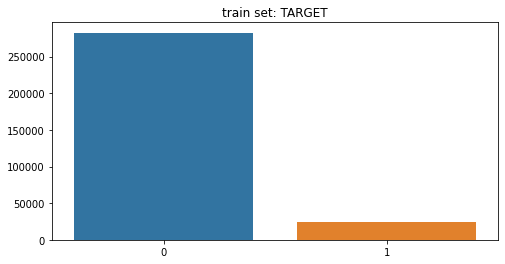

In [38]:
plot_categorical(data=application_train, col='TARGET', size=[8 ,4], xlabel_angle=0, title='train set: TARGET')

**Occupation Type :** 

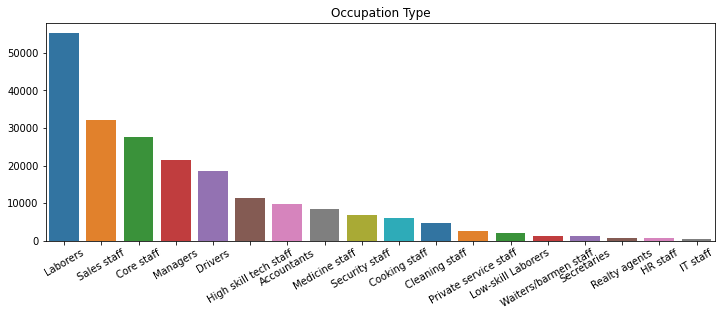

In [39]:
plot_categorical(data=application_train, col='OCCUPATION_TYPE', size=[12 ,4], xlabel_angle=30, title='Occupation Type')

**Gender :**

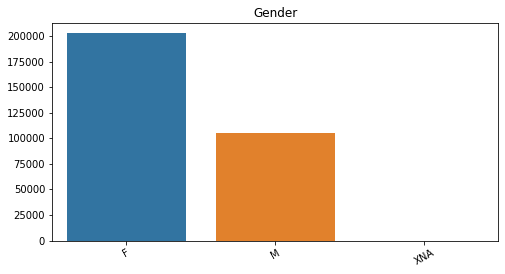

In [40]:
plot_categorical(data=application_train, col='CODE_GENDER', size=[8 ,4], xlabel_angle=30, title='Gender')

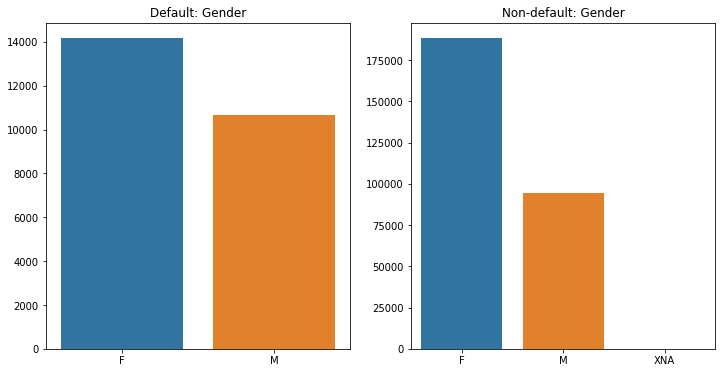

In [41]:
plot_categorical_bylabel(application_train, 'CODE_GENDER', title='Gender')

**Income Type :**

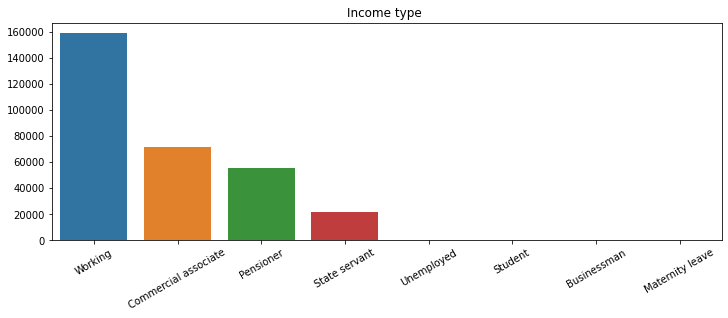

In [42]:
plot_categorical(data=application_train, col='NAME_INCOME_TYPE', size=[12 ,4], xlabel_angle=30, title='Income type ')

**House Type :**

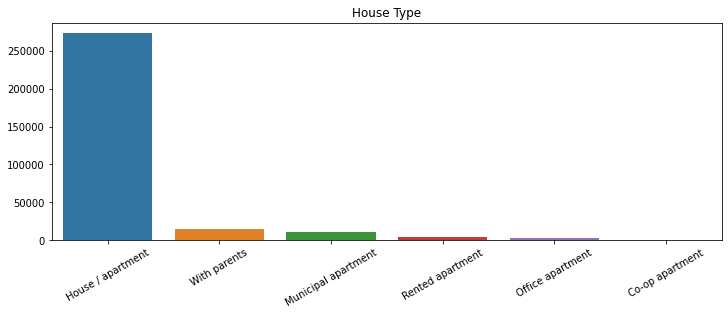

In [43]:
plot_categorical(data=application_train, col='NAME_HOUSING_TYPE', size=[12 ,4], xlabel_angle=30, title='House Type')

**Education Type :**

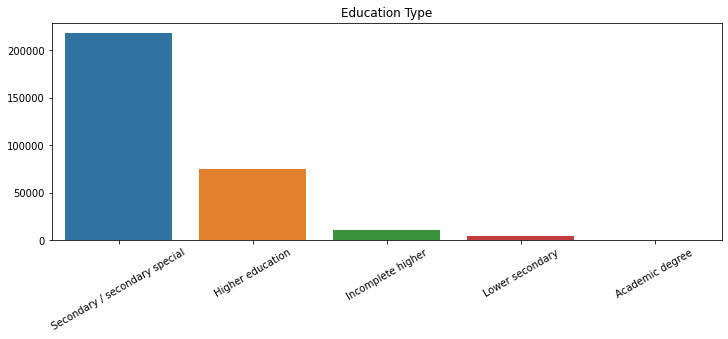

In [44]:
plot_categorical(data=application_train, col='NAME_EDUCATION_TYPE', size=[12 ,4], xlabel_angle=30, title='Education Type')

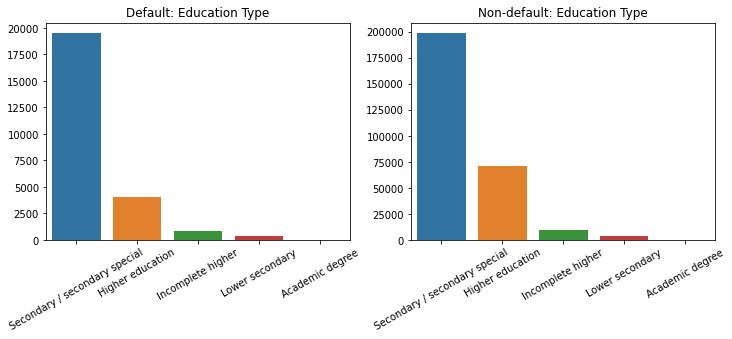

In [45]:
plot_categorical_bylabel(data=application_train, col='NAME_EDUCATION_TYPE', size=[12 ,4], xlabel_angle=30, title='Education Type')

### Quelsques Features Numériques

In [46]:
# Fonction pour l'histogramme des variables numériques
def plot_numerical(data, col, size=[8, 4], bins=50):
    '''use this for ploting the distribution of numercial features'''
    plt.figure(figsize=size)
    plt.title("Distribution of %s" % col)
    sns.distplot(data[col].dropna(), kde=True,bins=bins)
    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()
    
    
def plot_numerical_bylabel(data, col, size=[12, 6]):
    plt.figure(figsize=size)
    # Calculate the correlation coefficient between the new variable and the target
    corr = data['TARGET'].corr(data[col])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = data.loc[data['TARGET'] == 0, col].median()
    avg_not_repaid = data.loc[data['TARGET'] == 1, col].median()
    
    plt.figure(figsize = (12, 6))    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(data.loc[data['TARGET'] == 0, col], label = 'TARGET == 0')
    sns.kdeplot(data.loc[data['TARGET'] == 1, col], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(col); plt.ylabel('Density'); plt.title('%s Distribution' % col)
    plt.legend();    
    plt.show()
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (col, corr))
    

**Credit Amount :**

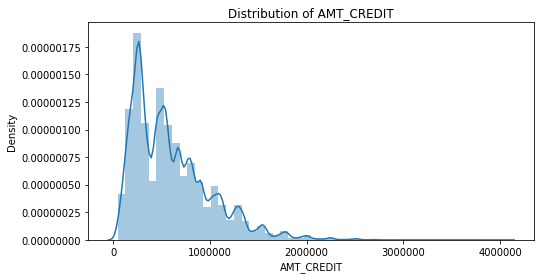

In [47]:
plot_numerical(application_train, 'AMT_CREDIT')

**Annuity Amount :**


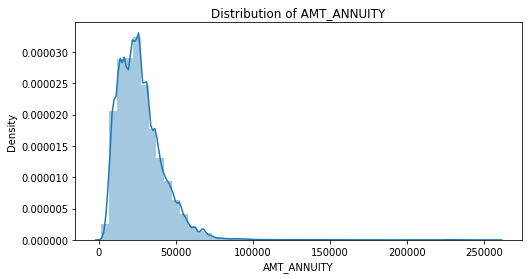

In [48]:
plot_numerical(application_train, 'AMT_ANNUITY')

**Days employed :**

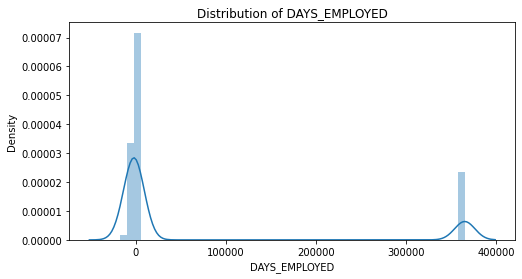

In [49]:
plot_numerical(application_train, 'DAYS_EMPLOYED', bins=50)

**EXT_SOURCE_1 :**

<Figure size 864x432 with 0 Axes>

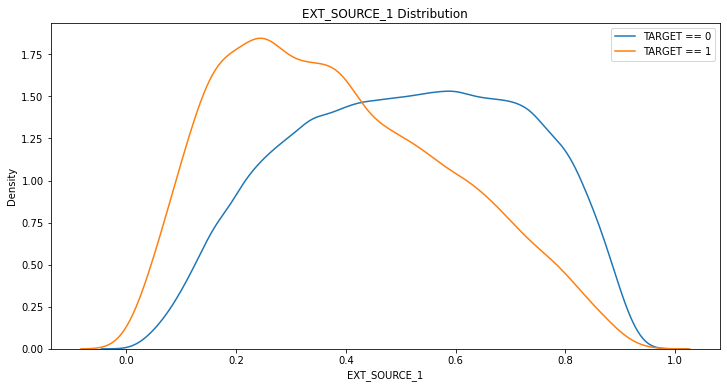

The correlation between EXT_SOURCE_1 and the TARGET is -0.1553


In [50]:
plot_numerical_bylabel(application_train, 'EXT_SOURCE_1')

**EXT_SOURCE_2 :**

<Figure size 864x432 with 0 Axes>

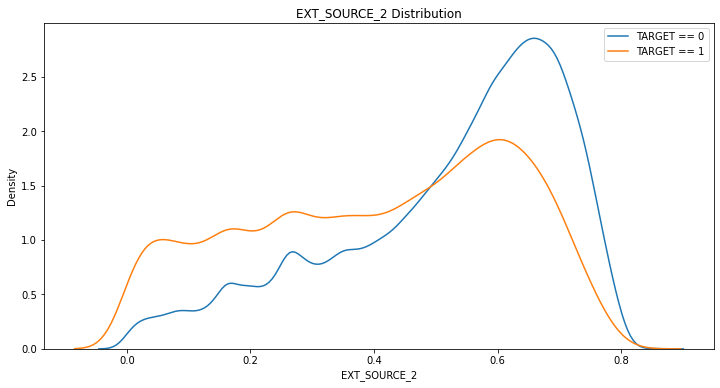

The correlation between EXT_SOURCE_2 and the TARGET is -0.1605


In [51]:
plot_numerical_bylabel(application_train, 'EXT_SOURCE_2')

**EXT_SOURCE_3 :**

<Figure size 864x432 with 0 Axes>

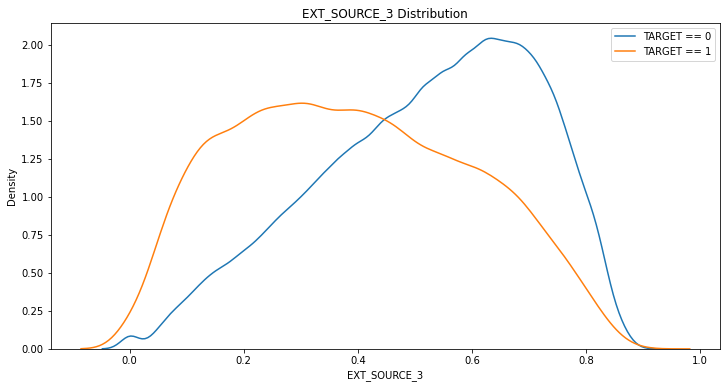

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789


In [52]:
plot_numerical_bylabel(application_train, 'EXT_SOURCE_3')

### Matrice de corrélation sur Application_train, variables quantitatives

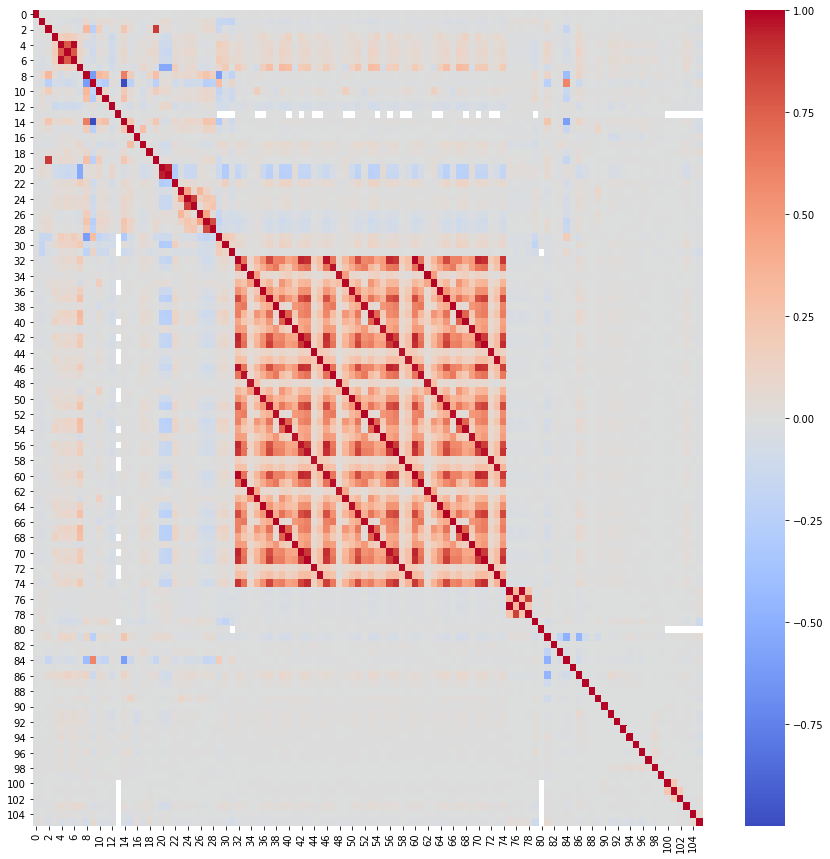

In [53]:
corr_mat = application_train.corr()
plt.figure(figsize=[15, 15])
sns.heatmap(corr_mat.values, annot=False,  cmap='coolwarm')
plt.show()

In [54]:
corr_mat

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000849,-0.001500,0.001366,-0.000973,-0.000384,0.001818,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,-0.002895,-0.001075,-0.001138,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.000082,0.002342,0.000222,0.001556,-0.002070,0.001551,0.005900,-0.001463,0.004862,-0.002879,0.004851,0.003083,0.001465,0.003119,0.001770,-0.002575,0.003042,0.001961,-0.001411,0.001890,0.005245,-0.001058,0.005017,-0.002844,0.004386,0.002081,0.001548,0.003589,0.002156,-0.001923,0.001920,0.001988,-0.001647,0.001366,0.005777,-0.001036,0.005067,-0.002583,0.004588,0.002837,0.001699,0.003272,0.002205,-0.003020,0.002440,0.002288,-0.001409,-0.000082,-0.001423,0.001187,-0.000858,0.000700,-0.003411,-0.004139,-0.001097,0.002121,-0.002694,0.001809,0.001505,-0.000815,-0.002012,-0.001045,0.000896,-0.001077,0.002604,-0.000724,0.001450,0.000509,0.000167,0.001073,0.000282,-0.002672,-0.002193,0.002099,0.000485,0.001025,0.004659
TARGET,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,0.051457,0.037612,0.000534,0.045982,0.028524,0.000370,-0.023806,-0.001758,0.009308,0.058899,0.060893,-0.024166,0.005576,0.006942,0.002819,0.044395,0.050994,0.032518,-0.155317,-0.160472,-0.178919,-0.029498,-0.022746,-0.009728,-0.022149,-0.018550,-0.034199,-0.019172,-0.044003,-0.033614,-0.010885,-0.025031,-0.032997,-0.003176,-0.013578,-0.027284,-0.019952,-0.009036,-0.022068,-0.016340,-0.032131,-0.017387,-0.043226,-0.032698,-0.010174,-0.023393,-0.030685,-0.001557,-0.012711,-0.029184,-0.022081,-0.009993,-0.022326,-0.018573,-0.033863,-0.019025,-0.043768,-0.033394,-0.011256,-0.024621,-0.032739,-0.002757,-0.013337,-0.032596,0.009131,0.032248,0.009022,0.031276,0.055218,0.005417,0.044346,-0.002672,-0.000316,-0.028602,-0.001520,-0.008040,-0.004352,-0.001414,-0.004229,-0.000756,-0.011583,-0.009464,-0.006536,-0.011615,-0.003378,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
CNT_CHILDREN,-0.001129,0.019187,1.0000

## Partage features numériques, catégorielles et discrete

In [55]:
def feature_type_split(data, special_list=[]):
    cat_list = []
    dis_num_list = []
    num_list = []
    for i in data.columns.tolist():
        if data[i].dtype == 'object':
            cat_list.append(i)
        elif data[i].nunique() < 25:
            dis_num_list.append(i)
        elif i in special_list:     # if you want to add some special cases
            dis_num_list.append(i)
        else:
            num_list.append(i)
    return cat_list, dis_num_list, num_list


In [56]:
cat_list, dis_num_list, num_list = feature_type_split(application_train, special_list=['AMT_REQ_CREDIT_BUREAU_YEAR']) 

print(str(len(cat_list)),'categorical features:', cat_list)
print('-----------------------------------------')
print(str(len(dis_num_list)),'discrete numerical features:',dis_num_list)
print('-----------------------------------------')
print(str(len(num_list)),'continuous numerical features:',num_list)


16 categorical features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
-----------------------------------------
46 discrete numerical features: ['TARGET', 'CNT_CHILDREN', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', '

## Création nouvelles features

Pas besoin de les créer sur le data test !




### Term: total credit / annuity

In [57]:
application_train = pd.read_csv('application_train.csv')

In [58]:
# some new features
application_train['TERM'] = application_train.AMT_CREDIT / application_train.AMT_ANNUITY
#application_test['TERM'] = application_test.AMT_CREDIT / application_test.AMT_ANNUITY

### OVER_EXPECT_CREDIT: actual credit larger than goods price

In [59]:
application_train['OVER_EXPECT_CREDIT'] = (application_train.AMT_CREDIT > application_train.AMT_GOODS_PRICE).map({False:0, True:1})
application_test['OVER_EXPECT_CREDIT'] = (application_test.AMT_CREDIT > application_test.AMT_GOODS_PRICE).map({False:0, True:1})

### MEAN_BUILDING_SCORE_TOTAL: the sum of all building AVG score

In [60]:
application_train['MEAN_BUILDING_SCORE_AVG'] = application_train.iloc[:, 44:58].mean(skipna=True, axis=1)
application_train['TOTAL_BUILDING_SCORE_AVG'] = application_train.iloc[:, 44:58].sum(skipna=True, axis=1)

#application_test['MEAN_BUILDING_SCORE_AVG'] = application_test.iloc[:, 44:58].mean(skipna=True, axis=1)
#application_test['TOTAL_BUILDING_SCORE_AVG'] = application_test.iloc[:, 44:58].sum(skipna=True, axis=1)

### FLAG_DOCUMENT_TOTAL: the total number of provided document

In [61]:
application_train['FLAG_DOCUMENT_TOTAL'] = application_train.iloc[:, 96:116].sum(axis=1)
#application_test['FLAG_DOCUMENT_TOTAL'] = application_test.iloc[:, 96:116].sum(axis=1)

### AMT_REQ_CREDIT_BUREAU_TOTAL: the total number of enquiries

In [62]:
application_train['AMT_REQ_CREDIT_BUREAU_TOTAL'] = application_train.iloc[:, 116:122].sum(axis=1)
#application_test['AMT_REQ_CREDIT_BUREAU_TOTAL'] = application_test.iloc[:, 116:122].sum(axis=1)

### BIRTH_EMPLOTED_INTERVEL: the days between born and employed

In [63]:
application_train['BIRTH_EMPLOTED_INTERVEL'] = application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH
#application_test['BIRTH_EMPLOTED_INTERVEL'] = application_test.DAYS_EMPLOYED - application_test.DAYS_BIRTH

In [64]:
application_train['BIRTH_REGISTRATION_INTERVEL'] = application_train.DAYS_REGISTRATION - application_train.DAYS_BIRTH
#application_test['BIRTH_REGISTRATION_INTERVEL'] = application_test.DAYS_REGISTRATION - application_test.DAYS_BIRTH

In [65]:
application_train['MEAN_BUILDING_SCORE_AVG'] = application_train.iloc[:, 44:58].mean(skipna=True, axis=1)
application_train['TOTAL_BUILDING_SCORE_AVG'] = application_train.iloc[:, 44:58].sum(skipna=True, axis=1)

#application_test['MEAN_BUILDING_SCORE_AVG'] = application_test.iloc[:, 44:58].mean(skipna=True, axis=1)
#application_test['TOTAL_BUILDING_SCORE_AVG'] = application_test.iloc[:, 44:58].sum(skipna=True, axis=1)

application_train['INCOME_PER_FAMILY_MEMBER'] = application_train.AMT_INCOME_TOTAL / application_train.CNT_FAM_MEMBERS
#application_test['INCOME_PER_FAMILY_MEMBER'] = application_test.AMT_INCOME_TOTAL / application_test.CNT_FAM_MEMBERS

application_train['SEASON_REMAINING'] = application_train.AMT_INCOME_TOTAL/4 -  application_train.AMT_ANNUITY
#application_test['SEASON_REMAINING'] = application_test.AMT_INCOME_TOTAL/4 -  application_test.AMT_ANNUITY

application_train['RATIO_INCOME_GOODS'] = application_train.AMT_INCOME_TOTAL -  application_train.AMT_GOODS_PRICE
#application_test['RATIO_INCOME_GOODS'] = application_test.AMT_INCOME_TOTAL -  application_test.AMT_GOODS_PRICE

application_train['CHILDREN_RATIO'] = application_train['CNT_CHILDREN'] / application_train['CNT_FAM_MEMBERS']
#application_test['CHILDREN_RATIO'] = application_test['CNT_CHILDREN'] / application_test['CNT_FAM_MEMBERS']


## Baseline model LGBMClassifier ATTENTION A DEPLACER


**A DEPLACER DANS LE NOTEBOOK DE MODELISATION !!!**




**application**: 'binary' for binary classification

**num_iterations**: number of boosting iterations/trees, **n_estimators** in sklearn

**learning_rate**

**num_leaves**: number of leaves in one tree

**feature_fraction**: part of features used for each iteration

**bagging_fraction**: part of data used for each iteration

**lambda_l1/lambda_l2**: L1/L2 regularization

**min_split_gain**: the minimun gain to perform a split

**early_stopping_round**: if the validation metric can't improve for n rounds, stop iteration

**categorical_feature**: LightGBM API can deal with categorical feature automatically, **but we need transform string into integer**

### Feature importance

## Extraction Features des autres Tables

### Features bureau & bureau_balance

In [66]:
# bb feature
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance['STATUS_mod'] = bureau_balance.STATUS.map({'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, 'X':np.nan, 'C':0}).map(lambda x: 0 if x=='C' else x).interpolate(method = 'linear')
bureau_balance['write_off'] = bureau_balance.STATUS.map(lambda x: 1 if x=='5' else 0)
bureau_balance['adj_score'] = (bureau_balance.MONTHS_BALANCE-bureau_balance.MONTHS_BALANCE.min()+1)*bureau_balance.STATUS_mod

bb_month_count = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].count()
bb_dpd_sum = bureau_balance.groupby('SK_ID_BUREAU')['STATUS_mod'].sum()
bb_write_off = bureau_balance.groupby('SK_ID_BUREAU')['write_off'].sum()
bb_dpd_sum_2_year = bureau_balance.loc[bureau_balance.MONTHS_BALANCE>=-24].groupby('SK_ID_BUREAU')['STATUS_mod'].sum()
bb_write_off_2_year = bureau_balance.loc[bureau_balance.MONTHS_BALANCE>=-24].groupby('SK_ID_BUREAU')['write_off'].sum()
bb_adj_score = bureau_balance.groupby('SK_ID_BUREAU')['adj_score'].sum()

bb_feature = pd.DataFrame({'bb_month_count':bb_month_count, 'bb_dpd_sum':bb_dpd_sum, 'bb_write_off':bb_write_off, 'bb_dpd_sum_2_year':bb_dpd_sum_2_year, 
                          'bb_write_off_2_year':bb_write_off_2_year, 'bb_adj_score': bb_adj_score}).reset_index().fillna(0)
del bb_month_count, bb_dpd_sum, bb_write_off, bb_dpd_sum_2_year, bb_write_off_2_year, bb_adj_score, bureau_balance
gc.collect()

# bureau
bureau = pd.read_csv('bureau.csv')
bureau = bureau.sort_values(['SK_ID_CURR', 'DAYS_CREDIT'])

bureau['ADJ_DAYS'] = (bureau.DAYS_CREDIT - bureau.DAYS_CREDIT.min()) / (bureau.DAYS_CREDIT.max() - bureau.DAYS_CREDIT.min()) + 0.5 # more recent, more effecitve
# application count
bur_ncount = bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()
bur_act_count = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['SK_ID_BUREAU'].count() # fillna: 0
bur_bad_count = bureau.loc[bureau.CREDIT_ACTIVE=='Bad debt'].groupby('SK_ID_CURR')['SK_ID_BUREAU'].count() # fillna: 0
bur_sold_count = bureau.loc[bureau.CREDIT_ACTIVE=='Sold out'].groupby('SK_ID_CURR')['SK_ID_BUREAU'].count() # fillna: 0
# application date
bur_recent_application = -bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].max()
bur_eariliest_application = -bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].min()
bur_max_enddate = -bureau.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].max()
# application itervel
bureau['application_interval'] = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].diff(-1)
missing_iter = iter(bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].max())
bureau.application_interval = bureau.application_interval.map(lambda x: -next(missing_iter) if np.isnan(x) else -x)
bur_avg_intervel = bureau.groupby('SK_ID_CURR')['application_interval'].mean()
bur_sd_intervel = bureau.groupby('SK_ID_CURR')['application_interval'].agg('std').fillna(0)
# overdue days
bur_max_overdue_days = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].max()
bur_active_total_overdue_days = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].sum()
bur_active_max_overdue_days = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].max()
bureau['DAYS_CREDIT_ISPAST'] = bureau.DAYS_CREDIT_ENDDATE.map(lambda x: 1 if x < 0 else 0)
bur_avg_remaining_days = bureau.loc[bureau.DAYS_CREDIT_ENDDATE>0].groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].mean()
# overdue amount
bureau['ADJ_AMT_CREDIT_MAX_OVERDUE'] = bureau.ADJ_DAYS * bureau.AMT_CREDIT_MAX_OVERDUE
bur_total_max_overdue_adj = bureau.groupby('SK_ID_CURR')['ADJ_AMT_CREDIT_MAX_OVERDUE'].sum() # use adj days
bur_avg_max_overdue = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].mean()
bur_overall_max_overdue = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].max()
# adj prelong
bureau['ADJ_CNT_CREDIT_PROLONG'] = bureau.ADJ_DAYS * bureau.CNT_CREDIT_PROLONG
bur_avg_prelonged = bureau.groupby('SK_ID_CURR')['ADJ_CNT_CREDIT_PROLONG'].mean().fillna(0) # use adj days
bur_max_prelonged = bureau.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].max().fillna(0)
bur_total_prelonged_adj = bureau.groupby('SK_ID_CURR')['ADJ_CNT_CREDIT_PROLONG'].sum().fillna(0)
# historical amount
bureau['ADJ_AMT_CREDIT_SUM_DEBT'] = bureau.ADJ_DAYS * bureau.AMT_CREDIT_SUM
bur_total_amount_adj = bureau.groupby('SK_ID_CURR')['ADJ_AMT_CREDIT_SUM_DEBT'].sum()
bur_avg_amount = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean()
# current amount
bur_active_total_amount = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum() # fillna 0
bur_active_avg_amount = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean() # fillna 0
bur_active_total_debt = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum() # fillna 0
bur_active_avg_debt = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].mean() # fillna 0
bur_active_total_limit  = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].sum() # fillna 0
bur_active_avg_limit  = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].mean() # fillna 0
bur_active_total_overdue = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum() # fillna 0
bur_active_avg_overdue = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].mean() # fillna 0
bur_active_ratio_debt_credit = (bur_active_total_debt / bur_active_total_amount.map(lambda x: x+0.1)) # fillna 0
bur_active_ratio_overdue_debt = (bur_active_total_overdue / bur_active_total_debt.map(lambda x: x+0.1)) # fillna 0
# credit update
bur_avg_update = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].mean()
bur_recent_update = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].max()
# annuity
bur_avg_annuity = bureau.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean() # can't fillna 0
bur_total_annuity = bureau.groupby('SK_ID_CURR')['AMT_ANNUITY'].sum() # can't fillna 0
bur_active_total_annuity = bureau.loc[bureau.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR')['AMT_ANNUITY'].sum()
bureau['term'] = bureau.AMT_CREDIT_SUM / bureau.AMT_ANNUITY
bur_avg_term = bureau.loc[bureau.term < float('inf')].groupby('SK_ID_CURR')['term'].mean() # can't fillna 0

bureau_num_feature = pd.DataFrame({'bur_ncount':bur_ncount, 'bur_act_count':bur_act_count, 'bur_bad_count':bur_bad_count, 'bur_sold_count':bur_sold_count,
            'bur_recent_application':bur_recent_application,'bur_eariliest_application':bur_eariliest_application, 'bur_max_enddate':bur_max_enddate,
            'bur_avg_intervel':bur_avg_intervel, 'bur_sd_intervel':bur_sd_intervel,
            'bur_max_overdue_days':bur_max_overdue_days, 'bur_active_total_overdue_days':bur_active_total_overdue_days, 'bur_active_max_overdue_days':bur_active_max_overdue_days,
            'bur_avg_remaining_days':bur_avg_remaining_days, 'bur_total_max_overdue_adj':bur_total_max_overdue_adj, 'bur_avg_max_overdue':bur_avg_max_overdue, 'bur_overall_max_overdue':bur_overall_max_overdue, 
            'bur_avg_prelonged':bur_avg_prelonged, 'bur_max_prelonged':bur_max_prelonged, 'bur_total_prelonged_adj':bur_total_prelonged_adj,
            'bur_total_amount_adj':bur_total_amount_adj, 'bur_avg_amount':bur_avg_amount,
            'bur_active_total_amount':bur_active_total_amount, 'bur_active_avg_amount':bur_active_avg_amount, 'bur_active_total_debt':bur_active_total_debt, 'bur_active_avg_debt':bur_active_avg_debt, 
            'bur_active_total_limit':bur_active_total_limit, 'bur_active_avg_limit':bur_active_avg_limit, 'bur_active_total_overdue':bur_active_total_overdue, 'bur_active_avg_overdue':bur_active_avg_overdue,
            'bur_active_ratio_debt_credit':bur_active_ratio_debt_credit, 'bur_active_ratio_overdue_debt':bur_active_ratio_overdue_debt,
            'bur_avg_update':bur_avg_update, 'bur_recent_update':bur_recent_update,
            'bur_avg_annuity':bur_avg_annuity, 'bur_total_annuity':bur_total_annuity, 'bur_active_total_annuity':bur_active_total_annuity, 'bur_avg_term':bur_avg_term}).reset_index()
fill0_list = ['bur_act_count', 'bur_bad_count', 'bur_sold_count', 'bur_active_total_overdue_days', 'bur_active_max_overdue_days', 'bur_active_total_amount', 'bur_active_avg_amount',
             'bur_active_total_debt', 'bur_active_avg_debt', 'bur_active_total_limit', 'bur_active_avg_limit', 'bur_active_total_overdue', 'bur_active_avg_overdue', 
              'bur_active_ratio_debt_credit', 'bur_active_ratio_overdue_debt', 'bur_active_total_annuity']
bureau_num_feature[fill0_list] = bureau_num_feature[fill0_list] .fillna(0)

bureau_cat = pd.get_dummies(bureau[['SK_ID_CURR','CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']], prefix='bur')
bureau_cat_feature = bureau_cat.groupby('SK_ID_CURR').mean().reset_index()
del bureau_cat
gc.collect()

bureau_bb = bureau[['SK_ID_CURR','SK_ID_BUREAU']].merge(bb_feature, on='SK_ID_BUREAU', how='left')

bb_avg_month = bureau_bb.groupby('SK_ID_CURR')['bb_month_count'].mean()
bb_total_overdue_month = bureau_bb.groupby('SK_ID_CURR')['bb_dpd_sum'].sum()
bb_total_writeoff = bureau_bb.groupby('SK_ID_CURR')['bb_write_off'].sum()
bb_max_overdue_month = bureau_bb.groupby('SK_ID_CURR')['bb_dpd_sum'].max()
bb_max_writeoff = bureau_bb.groupby('SK_ID_CURR')['bb_write_off'].max()

bb_total_overdue_month_2year = bureau_bb.groupby('SK_ID_CURR')['bb_dpd_sum_2_year'].sum()
bb_max_overdue_month_2year= bureau_bb.groupby('SK_ID_CURR')['bb_dpd_sum_2_year'].max()
bb_total_writeoff_2year = bureau_bb.groupby('SK_ID_CURR')['bb_write_off_2_year'].sum()
bb_max_writeoff_2year = bureau_bb.groupby('SK_ID_CURR')['bb_write_off_2_year'].max()

bb_max_score = bureau_bb.groupby('SK_ID_CURR')['bb_adj_score'].max()
bb_total_score = bureau_bb.groupby('SK_ID_CURR')['bb_adj_score'].sum()
bb_avg_score = bureau_bb.groupby('SK_ID_CURR')['bb_adj_score'].mean()

bureau_bb_feature = pd.DataFrame({'bb_avg_month':bb_avg_month, 
            'bb_total_overdue_month':bb_total_overdue_month, 'bb_total_writeoff':bb_total_writeoff, 'bur_sold_count':bb_max_overdue_month,'bb_max_writeoff':bb_max_writeoff,
            'bb_total_overdue_month_2year':bb_total_overdue_month_2year, 'bb_total_writeoff_2year':bb_total_writeoff_2year, 
            'bb_max_overdue_month_2year':bb_max_overdue_month_2year,'bb_max_writeoff_2year':bb_max_writeoff_2year, 
            'bb_max_score':bb_max_score, 'bb_total_score':bb_total_score, 'bb_avg_score':bb_avg_score}).reset_index()


bureau_feature = bureau_num_feature.merge(bureau_cat_feature, on='SK_ID_CURR').merge(bureau_bb_feature, on='SK_ID_CURR', how='left')

print(bureau_feature.shape)

(305811, 73)


In [67]:
bureau_feature

,SK_ID_CURR,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score
0,100001,7,3.0,0.0,0.0,49,1572,-1778.0,224.571429,227.190711,0,0.0,0.0,1030.333333,0.000000,NaN,NaN,0.000000,0,0.000000,1.897100e+06,2.076236e+05,884025.000,2.946750e+05,596686.500,1.988955e+05,0.000,0.0000,0.0,0.0,0.674966,0.0,-93.142857,-6,3545.357143,24817.500,24817.500,41.943113,0.428571,0.0,0.571429,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.571429,3.5,0.0,2.5,0.0,1.0,0.0,1.0,0.0,118.333333,215.333333,30.761905
1,100002,8,2.0,0.0,0.0,103,1437,-780.0,179.625000,160.904530,0,0.0,0.0,309.000000,10218.886725,1681.029,5043.645,0.000000,0,0.000000,9.958376e+05,1.081319e+05,481988.565,2.409943e+05,245781.000,1.228905e+05,31988.565,15994.2825,0.0,0.0,0.509931,0.0,-499.875000,-7,0.000000,0.000,0.000,NaN,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.750000,31.0,0.0,7.0,0.0,11.0,0.0,3.0,0.0,506.000000,2151.000000,268.875000
2,100003,4,1.0,0.0,0.0,606,2586,-1216.0,646.500000,350.128072,0,0.0,0.0,1216.000000,0.000000,0.000,0.000,0.000000,0,0.000000,1.256166e+06,2.543501e+05,810000.000,8.100000e+05,0.000,0.000000e+00,810000.000,810000.0000,0.0,0.0,0.000000,0.0,-816.000000,-43,NaN,0.000,0.000,NaN,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000000,NaN
3,100004,2,0.0,0.0,0.0,408,1326,382.0,663.000000,360.624458,0,0.0,0.0,NaN,0.000000,0.000,0.000,0.000000,0,0.000000,2.274724e+05,9.451890e+04,0.000,0.000000e+00,0.000,0.000000e+00,0.000,0.0000,0.0,0.0,0.000000,0.0,-532.000000,-382,NaN,0.000,0.000,NaN,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000000,NaN
4,100005,3,2.0,0.0,0.0,62,373,-1324.0,124.333333,96.924369,0,0.0,0.0,723.000000,0.000000,0.000,0.000,0.000000,0,0.000000,9.509199e+05,2.190420e+05,598626.000,2.993130e+05,568408.500,2.842042e+05,0.000,0.0000,0.0,0.0,0.949522,0.0,-54.333333,-11,1420.500000,4261.500,4261.500,6.998944,0.666667,0.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [68]:
bureau_feature.SK_ID_CURR.nunique()

305811

In [69]:
application_train.shape

(307511, 134)

### Features credit_card_balance

In [70]:

credit_card_balance = pd.read_csv('credit_card_balance.csv')
credit_card_balance = credit_card_balance.sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])

# count cards
ccb_prev_count = credit_card_balance.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
# INSTALMENTS
credit_card_balance['PAY_MONTH'] = credit_card_balance.CNT_INSTALMENT_MATURE_CUM.map(lambda x: 1 if x > 0 else 0)
ccb_temp = credit_card_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])['PAY_MONTH'].sum().reset_index()
ccb_avg_inst_card = ccb_temp.groupby('SK_ID_CURR')['PAY_MONTH'].mean()
ccb_total_inst_card = ccb_temp.groupby('SK_ID_CURR')['PAY_MONTH'].sum()
# limit
ccb_temp = credit_card_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])['AMT_CREDIT_LIMIT_ACTUAL'].mean().reset_index()
ccb_avg_limit_card = ccb_temp.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].mean()
ccb_max_limit_card = credit_card_balance.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].max()
ccb_total_limit_card = ccb_temp.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].sum()
# avg drawing amount
ccb_temp = credit_card_balance.loc[credit_card_balance.CNT_DRAWINGS_CURRENT>0].groupby(['SK_ID_CURR','MONTHS_BALANCE'])['AMT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_CURRENT'].sum().reset_index()
ccb_temp['avg_drawing_amount'] = (ccb_temp.AMT_DRAWINGS_CURRENT / ccb_temp.CNT_DRAWINGS_CURRENT).fillna(0)
ccb_avg_drawing_amount = ccb_temp.groupby('SK_ID_CURR')['avg_drawing_amount'].mean().fillna(0)
# count Refused
ccb_count_rej = credit_card_balance.groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg(lambda x: np.sum(x=='Refused'))
last_month_credit = credit_card_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])['MONTHS_BALANCE'].max().reset_index()
last_month_credit = last_month_credit.merge(credit_card_balance, on=['SK_ID_CURR','SK_ID_PREV', 'MONTHS_BALANCE'])
# current credit card situation
ccb_cur_total_receivable = last_month_credit.groupby('SK_ID_CURR')['AMT_TOTAL_RECEIVABLE'].sum()
ccb_cur_total_limit = last_month_credit.loc[last_month_credit.NAME_CONTRACT_STATUS == 'Active'].groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].sum() # fillna: 0
ccb_cur_total_payment = last_month_credit.groupby('SK_ID_CURR')['AMT_INST_MIN_REGULARITY'].sum()
ccb_cur_total_balance = last_month_credit.groupby('SK_ID_CURR')['AMT_BALANCE'].sum()
# drawing in 1y
ccb_temp = credit_card_balance.loc[credit_card_balance.MONTHS_BALANCE>=-12]
ccb_drawing_amount_1y = ccb_temp.groupby('SK_ID_CURR')['AMT_DRAWINGS_CURRENT'].sum()
ccb_drawing_times_1y = ccb_temp.groupby('SK_ID_CURR')['CNT_DRAWINGS_CURRENT'].sum()
# drawing in 6m
ccb_temp = credit_card_balance.loc[credit_card_balance.MONTHS_BALANCE>=-6]
ccb_drawing_amount_6m = ccb_temp.groupby('SK_ID_CURR')['AMT_DRAWINGS_CURRENT'].sum()
ccb_drawing_times_6m = ccb_temp.groupby('SK_ID_CURR')['CNT_DRAWINGS_CURRENT'].sum()
# DPD
ccb_temp = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV', 'SK_DPD', 'SK_DPD_DEF']].groupby(['SK_ID_CURR','SK_ID_PREV'])['SK_DPD','SK_DPD_DEF'].max().reset_index()
ccb_max_dpd_days = ccb_temp.groupby('SK_ID_CURR')['SK_DPD'].max()
ccb_total_dpd_days = ccb_temp.groupby('SK_ID_CURR')['SK_DPD'].sum()
ccb_max_largedpd_days = ccb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()
ccb_total_largedpd_days = ccb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].sum()

ccb_feature = pd.DataFrame({'ccb_prev_count':ccb_prev_count, 'ccb_avg_inst_card':ccb_avg_inst_card, 'ccb_avg_limit_card':ccb_avg_limit_card, 'ccb_total_inst_card':ccb_total_inst_card, 'ccb_count_rej': ccb_count_rej,
                        'ccb_avg_limit_card':ccb_avg_limit_card, 'ccb_max_limit_card':ccb_max_limit_card, 'ccb_total_limit_card':ccb_total_limit_card, 'ccb_avg_drawing_amount':ccb_avg_drawing_amount,
                        'ccb_cur_total_receivable':ccb_cur_total_receivable, 'ccb_cur_total_limit':ccb_cur_total_limit, 'ccb_cur_total_payment':ccb_cur_total_payment, 'ccb_cur_total_balance':ccb_cur_total_balance,
                        'ccb_drawing_amount_1y':ccb_drawing_amount_1y, 'ccb_drawing_times_1y':ccb_drawing_times_1y, 'ccb_drawing_amount_6m':ccb_drawing_amount_6m, 'ccb_drawing_times_6m':ccb_drawing_times_6m,
                        'ccb_max_dpd_days':ccb_max_dpd_days, 'ccb_total_dpd_days':ccb_total_dpd_days, 'ccb_max_largedpd_days':ccb_max_largedpd_days, 'ccb_total_largedpd_days':ccb_total_largedpd_days}).reset_index()

In [71]:
ccb_feature.shape

(103558, 21)

In [72]:
ccb_feature

,SK_ID_CURR,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total_inst_card,ccb_count_rej,ccb_max_limit_card,ccb_total_limit_card,ccb_avg_drawing_amount,ccb_cur_total_receivable,ccb_cur_total_limit,ccb_cur_total_payment,ccb_cur_total_balance,ccb_drawing_amount_1y,ccb_drawing_times_1y,ccb_drawing_amount_6m,ccb_drawing_times_6m,ccb_max_dpd_days,ccb_total_dpd_days,ccb_max_largedpd_days,ccb_total_largedpd_days
0,100006,1,0.0,270000.000000,0,0,270000,270000.000000,NaN,0.000,270000.0,0.00,0.000,0.00,0,0.00,0.0,0,0,0,0
1,100011,1,73.0,164189.189189,73,0,180000,164189.189189,45000.000000,0.000,90000.0,0.00,0.000,0.00,0,0.00,0.0,0,0,0,0
2,100013,1,89.0,131718.750000,89,0,157500,131718.750000,25778.571429,0.000,45000.0,0.00,0.000,0.00,0,0.00,0.0,1,1,1,1
3,100021,1,0.0,675000.000000,0,0,675000,675000.000000,NaN,0.000,NaN,0.00,0.000,0.00,0,0.00,0.0,0,0,0,0
4,100023,1,0.0,135000.000000,0,0,225000,135000.000000,NaN,0.000,225000.0,0.00,0.000,0.00,0,0.00,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,1,40.0,296341.463415,40,0,450000,296341.463415,17956.233750,0.000,NaN,0.00,0.000,154.26,0,154.26,0.0,0,0,0,0
103554,456246,1,7.0,135000.000000,7,0,135000,135000.000000,6578.489062,62.190,135000.0,130.50,62.685,121594.05,20,46560.15,9.0,0,0,0,0
103555,456247,1,95.0,144000.000000,95,0,180000,144000.000000,12988.367500,0.000,0.0,0.00,0.000,0.00,0,0.00,0.0,1,1,1,1
103556,456248,1,0.0,900000.000000,0,0,900000,900000.000000,NaN,0.000,900000.0,0.00,0.000,0.00,0,0.00,0.0,0,0,0,0


In [73]:
ccb_feature.SK_ID_CURR.nunique()

103558

### Features installments_payments

In [74]:
installments_payments = pd.read_csv('installments_payments.csv')
installments_payments = installments_payments.sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

previous_application = pd.read_csv("previous_application.csv")
previous_application = previous_application.sort_values(['SK_ID_CURR', 'DAYS_DECISION'])

# recent application
recent_record = installments_payments.merge(installments_payments.groupby('SK_ID_CURR')['SK_ID_PREV'].max().reset_index().drop('SK_ID_CURR', axis=1), on='SK_ID_PREV')
ip_recent_term = recent_record.groupby('SK_ID_CURR')['NUM_INSTALMENT_NUMBER'].max()
ip_recent_total_actual_payment = recent_record.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_recent_total_required_payment = recent_record.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()
# recent late & less time 
recent_record['is_late'] = (recent_record.DAYS_INSTALMENT < recent_record.DAYS_ENTRY_PAYMENT).map(lambda x: 1 if x==True else 0).fillna(0)
recent_record['is_less'] = (recent_record.AMT_INSTALMENT > recent_record.AMT_PAYMENT).map(lambda x: 1 if x==True else 0).fillna(0)
ip_recent_total_late_times = recent_record.groupby('SK_ID_CURR')['is_late'].sum()
ip_recent_total_less_times = recent_record.groupby('SK_ID_CURR')['is_less'].sum()
# recent late & less amount
ip_temp1 = recent_record.loc[recent_record.is_late==1]
ip_temp2 = recent_record.loc[recent_record.is_less==1]
ip_temp1['total_late'] = ip_temp1.DAYS_ENTRY_PAYMENT - ip_temp1.DAYS_INSTALMENT
ip_temp2['total_less'] = ip_temp2.AMT_INSTALMENT - ip_temp2.AMT_PAYMENT
ip_recent_total_late_days = ip_temp1.groupby('SK_ID_CURR')['total_late'].sum()
ip_recent_total_less_amount = ip_temp2.groupby('SK_ID_CURR')['total_less'].sum()
del ip_temp1, ip_temp2
gc.collect()

# previous application times
ip_prev_count = installments_payments.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
ip_payment_count = installments_payments.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
# credit card
installments_payments['IS_CREDIT'] = installments_payments.NUM_INSTALMENT_VERSION.map(lambda x: 1 if x==0 else 0)
ip_creditcard_user = installments_payments.groupby('SK_ID_CURR')['IS_CREDIT'].sum().map(lambda x: 1 if x>0 else 0)
ip_creditcard_count = installments_payments.groupby(['SK_ID_CURR','SK_ID_PREV'])['IS_CREDIT'].sum().map(lambda x: 1 if x>0 else 0).reset_index().groupby('SK_ID_CURR')['IS_CREDIT'].sum()
# change times
ip_temp = (installments_payments.groupby(['SK_ID_CURR','SK_ID_PREV'])['NUM_INSTALMENT_VERSION'].nunique()-1).reset_index()
ip_total_change_times = ip_temp.groupby('SK_ID_CURR')['NUM_INSTALMENT_VERSION'].sum()
ip_avg_change_times = ip_temp.groupby('SK_ID_CURR')['NUM_INSTALMENT_VERSION'].mean()
# avg instl
ip_temp = installments_payments.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['NUM_INSTALMENT_NUMBER'].max().reset_index()
ip_avg_instl = ip_temp.groupby('SK_ID_CURR')['NUM_INSTALMENT_NUMBER'].mean()
ip_max_instl = ip_temp.groupby('SK_ID_CURR')['NUM_INSTALMENT_NUMBER'].max()
# total late & less time 
installments_payments['is_late'] = (installments_payments.DAYS_INSTALMENT < installments_payments.DAYS_ENTRY_PAYMENT).map(lambda x: 1 if x==True else 0).fillna(0)
installments_payments['is_less'] = (installments_payments.AMT_INSTALMENT > installments_payments.AMT_PAYMENT).map(lambda x: 1 if x==True else 0).fillna(0)
ip_total_late_times = installments_payments.groupby('SK_ID_CURR')['is_late'].sum()
ip_total_less_times = installments_payments.groupby('SK_ID_CURR')['is_less'].sum()
# total late & less amount
ip_temp1 = installments_payments.loc[installments_payments.is_late==1]
ip_temp2 = installments_payments.loc[installments_payments.is_less==1]
ip_temp1['total_late'] = ip_temp1.DAYS_ENTRY_PAYMENT - ip_temp1.DAYS_INSTALMENT
ip_temp2['total_less'] = ip_temp2.AMT_INSTALMENT - ip_temp2.AMT_PAYMENT
ip_total_late_days = ip_temp1.groupby('SK_ID_CURR')['total_late'].sum()
ip_total_less_amount = ip_temp2.groupby('SK_ID_CURR')['total_less'].sum()
del ip_temp1, ip_temp2
gc.collect()
# total payment
ip_total_actual_payment = installments_payments.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_total_required_payment = installments_payments.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()

# total late & less time in recent 1 year
ip_1y = installments_payments.loc[installments_payments.DAYS_ENTRY_PAYMENT>-365]
# payment 1 year
ip_payment_count_1y = ip_1y.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
ip_creditcard_count_1y = ip_1y.groupby(['SK_ID_CURR','SK_ID_PREV'])['IS_CREDIT'].sum().map(lambda x: 1 if x>0 else 0).reset_index().groupby('SK_ID_CURR')['IS_CREDIT'].sum()
ip_total_late_times_1y = ip_1y.groupby('SK_ID_CURR')['is_late'].sum()
ip_total_less_times_1y = ip_1y.groupby('SK_ID_CURR')['is_less'].sum()
# avg instl
ip_temp = ip_1y.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['NUM_INSTALMENT_NUMBER'].max().reset_index()
ip_avg_instl_1y = ip_temp.groupby('SK_ID_CURR')['NUM_INSTALMENT_NUMBER'].mean()
# total late & less amount
ip_temp1 = ip_1y.loc[ip_1y.is_late==1]
ip_temp2 = ip_1y.loc[ip_1y.is_less==1]
ip_temp1['total_late'] = ip_temp1.DAYS_ENTRY_PAYMENT - ip_temp1.DAYS_INSTALMENT
ip_temp2['total_less'] = ip_temp2.AMT_INSTALMENT - ip_temp2.AMT_PAYMENT
ip_total_late_days_1y = ip_temp1.groupby('SK_ID_CURR')['total_late'].sum()
ip_total_less_amount_1y = ip_temp2.groupby('SK_ID_CURR')['total_less'].sum()
del ip_temp1, ip_temp2
gc.collect()
# total payment
ip_total_actual_payment_1y = ip_1y.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_total_required_payment_1y = ip_1y.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()

# total late & less time in recent 6 months
ip_6m = installments_payments.loc[installments_payments.DAYS_ENTRY_PAYMENT>-180]
ip_payment_count_6m = ip_6m.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
ip_creditcard_count_6m = ip_6m.groupby(['SK_ID_CURR','SK_ID_PREV'])['IS_CREDIT'].sum().map(lambda x: 1 if x>0 else 0).reset_index().groupby('SK_ID_CURR')['IS_CREDIT'].sum()
ip_total_late_times_6m = ip_6m.groupby('SK_ID_CURR')['is_late'].sum()
ip_total_less_times_6m = ip_6m.groupby('SK_ID_CURR')['is_less'].sum()
# avg instl
ip_temp = ip_6m.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['NUM_INSTALMENT_NUMBER'].max().reset_index()
ip_avg_instl_6m = ip_temp.groupby('SK_ID_CURR')['NUM_INSTALMENT_NUMBER'].mean()
# total late & less amount
ip_temp1 = ip_6m.loc[ip_6m.is_late==1]
ip_temp2 = ip_6m.loc[ip_6m.is_less==1]
ip_temp1['total_late'] = ip_temp1.DAYS_ENTRY_PAYMENT - ip_temp1.DAYS_INSTALMENT
ip_temp2['total_less'] = ip_temp2.AMT_INSTALMENT - ip_temp2.AMT_PAYMENT
ip_total_late_days_6m = ip_temp1.groupby('SK_ID_CURR')['total_late'].sum()
ip_total_less_amount_6m = ip_temp2.groupby('SK_ID_CURR')['total_less'].sum()
del ip_temp1, ip_temp2
gc.collect()
# total payment
ip_total_actual_payment_6m = ip_6m.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_total_required_payment_6m = ip_6m.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()

ip_feature = pd.DataFrame({'ip_prev_count':ip_prev_count, 'ip_payment_count':ip_payment_count, 'ip_creditcard_user':ip_creditcard_user, 'ip_creditcard_count':ip_creditcard_count,
                           'ip_total_change_times':ip_total_change_times, 'ip_avg_change_times':ip_avg_change_times, 'ip_avg_instl':ip_avg_instl, 'ip_max_instl':ip_max_instl,
                           'ip_total_late_times':ip_total_late_times, 'ip_total_less_times':ip_total_less_times, 'ip_total_late_days':ip_total_late_days, 'ip_total_less_amount':ip_total_less_amount,
                           'ip_total_actual_payment':ip_total_actual_payment, 'ip_total_required_payment':ip_total_required_payment,
                           'ip_recent_term':ip_recent_term, 'ip_recent_total_actual_payment':ip_recent_total_actual_payment, 'ip_recent_total_required_payment':ip_recent_total_required_payment,
                           'ip_recent_total_late_times':ip_recent_total_late_times, 'ip_recent_total_less_times':ip_recent_total_less_times, 
                           'ip_recent_total_late_days':ip_recent_total_late_days, 'ip_recent_total_less_amount':ip_recent_total_less_amount}).fillna(0)

ip_1y = pd.DataFrame({'ip_payment_count_1y':ip_payment_count_1y, 'ip_creditcard_count_1y': ip_creditcard_count_1y, 'ip_avg_instl_1y':ip_avg_instl_1y,
                      'ip_total_late_times_1y':ip_total_late_times_1y, 'ip_total_less_times_1y':ip_total_less_times_1y, 'ip_total_late_days_1y':ip_total_late_days_1y,
                      'ip_total_less_amount_1y':ip_total_less_amount_1y, 'ip_total_actual_payment_1y':ip_total_actual_payment_1y, 'ip_total_required_payment_1y':ip_total_required_payment_1y}).reset_index().fillna(0)

ip_6m = pd.DataFrame({'ip_payment_count_6m':ip_payment_count_6m, 'ip_creditcard_count_6m': ip_creditcard_count_6m, 'ip_avg_instl_6m':ip_avg_instl_6m,
                      'ip_total_late_times_6m':ip_total_late_times_6m, 'ip_total_less_times_6m':ip_total_less_times_6m, 'ip_total_late_days_6m':ip_total_late_days_6m,
                      'ip_total_less_amount_6m':ip_total_less_amount_6m, 'ip_total_actual_payment_6m':ip_total_actual_payment_6m, 'ip_total_required_payment_6m':ip_total_required_payment_6m}).reset_index().fillna(0)
ip_feature = ip_feature.merge(ip_1y, on='SK_ID_CURR', how='left').merge(ip_6m, on='SK_ID_CURR', how='left')
ip_feature['ip_active_1y'] = ip_feature.ip_total_late_times_1y.notnull().map(lambda x: 1 if x==True else 0)
ip_feature['ip_active_6m'] = ip_feature.ip_total_late_times_6m.notnull().map(lambda x: 1 if x==True else 0)

# active account
ACCOUNT_1Y = installments_payments.groupby('SK_ID_PREV')['DAYS_ENTRY_PAYMENT'].max().map(lambda x: 1 if x>=-365 else 0)
ACCOUNT_6M = installments_payments.groupby('SK_ID_PREV')['DAYS_ENTRY_PAYMENT'].max().map(lambda x: 1 if x>=-180 else 0)
ACTIVE_ACCOUNT = pd.DataFrame({'ACCOUNT_1Y':ACCOUNT_1Y, 'ACCOUNT_6M':ACCOUNT_6M}).reset_index()

pa_ip = previous_application[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE']].merge(ACTIVE_ACCOUNT, on='SK_ID_PREV', how='left')
COUNT_1Y = pd.get_dummies(pa_ip.loc[pa_ip.ACCOUNT_1Y==1, ['SK_ID_CURR', 'NAME_CONTRACT_TYPE']], prefix='ip_count_1y_').groupby('SK_ID_CURR').sum().reset_index()
COUNT_6M = pd.get_dummies(pa_ip.loc[pa_ip.ACCOUNT_6M==1, ['SK_ID_CURR', 'NAME_CONTRACT_TYPE']], prefix='ip_count_6m_').groupby('SK_ID_CURR').sum().reset_index()
ip_feature = ip_feature.merge(COUNT_1Y, on='SK_ID_CURR', how='left').merge(COUNT_6M, on='SK_ID_CURR', how='left')
for i in range(-6, 0):
    ip_feature.iloc[:, i] = ip_feature.iloc[:, i].fillna(0)
    




In [75]:
ip_feature

,SK_ID_CURR,ip_prev_count,ip_payment_count,ip_creditcard_user,ip_creditcard_count,ip_total_change_times,ip_avg_change_times,ip_avg_instl,ip_max_instl,ip_total_late_times,ip_total_less_times,ip_total_late_days,ip_total_less_amount,ip_total_actual_payment,ip_total_required_payment,ip_recent_term,ip_recent_total_actual_payment,ip_recent_total_required_payment,ip_recent_total_late_times,ip_recent_total_less_times,ip_recent_total_late_days,ip_recent_total_less_amount,ip_payment_count_1y,ip_creditcard_count_1y,ip_avg_instl_1y,ip_total_late_times_1y,ip_total_less_times_1y,ip_total_late_days_1y,ip_total_less_amount_1y,ip_total_actual_payment_1y,ip_total_required_payment_1y,ip_payment_count_6m,ip_creditcard_count_6m,ip_avg_instl_6m,ip_total_late_times_6m,ip_total_less_times_6m,ip_total_late_days_6m,ip_total_less_amount_6m,ip_total_actual_payment_6m,ip_total_required_payment_6m,ip_active_1y,ip_active_6m,ip_count_1y__Cash loans,ip_count_1y__Consumer loans,ip_count_1y__Revolving loans,ip_count_6m__Cash loans,ip_count_6m__Consumer loans,ip_count_6m__Revolving loans
0,100001,2,7,0,0,1,0.500000,4.000000,4,1,0,11.0,0.000,41195.925,41195.925,4,11945.025,11945.025,1,0,11.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,1,19,0,0,1,1.000000,19.000000,19,0,0,0.0,0.000,219625.695,219625.695,19,219625.695,219625.695,0,0,0.0,0.0,11.0,0.0,19.0,0.0,0.0,0.0,0.00,145611.495,145611.495,5.0,0.0,19.0,0.0,0.0,0.0,0.00,90100.845,90100.845,1,1,0.0,1.0,0.0,0.0,1.0,0.0
2,100003,3,25,0,0,1,0.333333,8.333333,12,0,0,0.0,0.000,1618864.650,1618864.650,6,387113.940,387113.940,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,1,3,0,0,1,1.000000,3.000000,3,0,0,0.0,0.000,21288.465,21288.465,3,21288.465,21288.465,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,1,9,0,0,1,1.000000,9.000000,9,1,0,1.0,0.000,56161.845,56161.845,9,56161.845,56161.845,1,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,1,7,0,0,1,1.000000,7.000000,7,0,0,0.0,0.000,52450.470,52450.470,7,52450.470,52450.470,0,0,0.0,0.0,7.0,0.0,7.0,0.0,0.0,0.0,0.00,52450.470,52450.470,4.0,0.0,7.0,0.0,0.0,0.0,0.00,32632.740,32632.740,1,1,0.0,1.0,0.0,0.0,1.0,0.0
339583,456252,1,6,0,0,0,0.000000,6.000000,6,1,0,3.0,0.000,60419.205,60419.205,6,60419.205,60419.205,1,0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0
339584,456253,3,14,0,0,0,0.000000,7.333333,12,1,2,9.0,3973.095,57622.815,61595.910,12,8317.890,8317.890,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0
339585,456254,2,19,0,0,0,0.000000,9.500000,10,0,0,0.0,0.000,194556.825,194556.825,9,171592.425,171592.425,0,0,0.0,0.0,19.0,0.0,9.5,0.0,0.0,0.0,0.00,194556.825,194556.825,11.0,0.0,9.5,0.0,0.0,0.0,0.00,125877.150,125877.150,1,1,0.0,2.0,0.0,0.0,2.0,0.0


In [76]:
ip_feature.SK_ID_CURR.nunique()

339587

In [77]:
application_train.shape

(307511, 134)

In [78]:
application_test.shape

(48744, 122)

### Features POS_CASH_balance

In [79]:
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
POS_CASH_balance = POS_CASH_balance.sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])

pcb_prev_count = POS_CASH_balance.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
pcb_avg_month = POS_CASH_balance.groupby('SK_ID_CURR')['MONTHS_BALANCE'].count()/pcb_prev_count
pcb_recent_active = POS_CASH_balance.groupby('SK_ID_CURR')['MONTHS_BALANCE'].max()

# times of INSTALMENT change
pcb_temp_inst_change_time = POS_CASH_balance[['SK_ID_PREV', 'CNT_INSTALMENT']].groupby('SK_ID_PREV')['CNT_INSTALMENT'].nunique().map(lambda x: x - 1).reset_index().rename(columns={'CNT_INSTALMENT':'pcb_prev_inst_change_time'})
pcb_temp = POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].count().reset_index()
pcb_temp = pcb_temp.merge(pcb_temp_inst_change_time, on='SK_ID_PREV')
pcb_inst_change_time = pcb_temp.groupby('SK_ID_CURR')['pcb_prev_inst_change_time'].sum()

# avg INSTALMENT
pcb_temp = POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT'].mean().reset_index()
pcb_avg_inst = pcb_temp.groupby(['SK_ID_CURR'])['CNT_INSTALMENT'].mean()

# active INSTALMENT
pcb_temp = POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].max().reset_index()
pcb_temp = pcb_temp.merge(POS_CASH_balance[['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS']], on=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])
pcb_temp['active_1'] = pcb_temp.MONTHS_BALANCE.map(lambda x: 1 if x>=-4 else 0)
pcb_temp['active_2'] = pcb_temp.NAME_CONTRACT_STATUS.map(lambda x: 1 if x=='Active' else 0)
pcb_temp['active'] = pcb_temp.active_1 * pcb_temp.active_2
pcb_active_inst = pcb_temp.groupby('SK_ID_CURR')['active'].count()

# DPD
pcb_temp = POS_CASH_balance[['SK_ID_CURR', 'SK_ID_PREV', 'SK_DPD', 'SK_DPD_DEF']].groupby(['SK_ID_CURR','SK_ID_PREV'])['SK_DPD','SK_DPD_DEF'].max().reset_index()
pcb_max_dpd_days = pcb_temp.groupby('SK_ID_CURR')['SK_DPD'].max()
pcb_total_dpd_days = pcb_temp.groupby('SK_ID_CURR')['SK_DPD'].sum()
pcb_max_largedpd_days = pcb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()
pcb_total_largedpd_days = pcb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].sum()

pcb_temp = POS_CASH_balance.loc[POS_CASH_balance.MONTHS_BALANCE>=-12, ['SK_ID_CURR', 'SK_ID_PREV', 'SK_DPD', 'SK_DPD_DEF']].groupby(['SK_ID_CURR','SK_ID_PREV'])['SK_DPD','SK_DPD_DEF'].max().reset_index()
pcb_max_dpd_days_1y = pcb_temp.groupby('SK_ID_CURR')['SK_DPD'].max()
pcb_total_dpd_days_1y = pcb_temp.groupby('SK_ID_CURR')['SK_DPD'].sum()
pcb_max_largedpd_days_1y = pcb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()
pcb_total_largedpd_days_1y = pcb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].sum()

pcb_temp = POS_CASH_balance.loc[POS_CASH_balance.MONTHS_BALANCE>=-24, ['SK_ID_CURR', 'SK_ID_PREV', 'SK_DPD', 'SK_DPD_DEF']].groupby(['SK_ID_CURR','SK_ID_PREV'])['SK_DPD','SK_DPD_DEF'].max().reset_index()
pcb_max_dpd_days_2y = pcb_temp.groupby('SK_ID_CURR')['SK_DPD'].max()
pcb_total_dpd_days_2y = pcb_temp.groupby('SK_ID_CURR')['SK_DPD'].sum()
pcb_max_largedpd_days_2y = pcb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()
pcb_total_largedpd_days_2y = pcb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].sum()

pcb_num = pd.DataFrame({'pcb_prev_count':pcb_prev_count, 'pcb_avg_month':pcb_avg_month, 'pcb_recent_active':pcb_recent_active, 'pcb_inst_change_time':pcb_inst_change_time,
                       'pcb_avg_inst':pcb_avg_inst, 'pcb_active_inst':pcb_active_inst, 
                       'pcb_max_dpd_days':pcb_max_dpd_days, 'pcb_total_dpd_days':pcb_total_dpd_days, 'pcb_max_largedpd_days':pcb_max_largedpd_days, 'pcb_total_largedpd_days':pcb_total_largedpd_days,
                       'pcb_max_dpd_days_1y':pcb_max_dpd_days_1y, 'pcb_total_dpd_days_1y':pcb_total_dpd_days_1y, 'pcb_max_largedpd_days_1y':pcb_max_largedpd_days_1y, 
                       'pcb_total_largedpd_days_1y':pcb_total_largedpd_days_1y, 'pcb_max_dpd_days_2y':pcb_max_dpd_days_2y, 'pcb_total_dpd_days_2y':pcb_total_dpd_days_2y, 
                       'pcb_max_largedpd_days_2y':pcb_max_largedpd_days_2y, 'pcb_total_largedpd_days_2y':pcb_total_largedpd_days_2y,}).reset_index()

# INSTALMENT: ratio of end status of each type
pcb_temp = POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].max().reset_index()
pcb_temp = pcb_temp.merge(POS_CASH_balance[['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS']], on=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])
pcb_temp_dummy = pd.get_dummies(pcb_temp, prefix='pcb_end_as')
pcb_end_as_dummy = pcb_temp_dummy.loc[pcb_temp_dummy.pcb_end_as_Active!=1].drop(['SK_ID_PREV','MONTHS_BALANCE', 'pcb_end_as_Active'], axis=1).groupby('SK_ID_CURR').sum().reset_index()
del pcb_temp_dummy
gc.collect()

pcb_feature = pcb_num.merge(pcb_end_as_dummy, on='SK_ID_CURR', how='left')

pcb_feature['pcb_no_dpd'] = pcb_feature.pcb_total_dpd_days.map(lambda x: 0 if x== 0 else 1)
pcb_feature['pcb_no_largedpd'] = pcb_feature.pcb_total_largedpd_days.map(lambda x: 0 if x== 0 else 1)
pcb_feature['pcb_no_dpd_1y'] = pcb_feature.pcb_total_dpd_days_1y.map(lambda x: 0 if x== 0 else 1)
pcb_feature['pcb_no_largedpd_1y'] = pcb_feature.pcb_total_largedpd_days_1y.map(lambda x: 0 if x== 0 else 1)
pcb_feature['pcb_no_dpd_2y'] = pcb_feature.pcb_total_dpd_days_2y.map(lambda x: 0 if x== 0 else 1)
pcb_feature['pcb_no_largedpd_2y'] = pcb_feature.pcb_total_largedpd_days_2y.map(lambda x: 0 if x== 0 else 1)


In [80]:
pcb_feature

,SK_ID_CURR,pcb_prev_count,pcb_avg_month,pcb_recent_active,pcb_inst_change_time,pcb_avg_inst,pcb_active_inst,pcb_max_dpd_days,pcb_total_dpd_days,pcb_max_largedpd_days,pcb_total_largedpd_days,pcb_max_dpd_days_1y,pcb_total_dpd_days_1y,pcb_max_largedpd_days_1y,pcb_total_largedpd_days_1y,pcb_max_dpd_days_2y,pcb_total_dpd_days_2y,pcb_max_largedpd_days_2y,pcb_total_largedpd_days_2y,pcb_end_as_Amortized debt,pcb_end_as_Approved,pcb_end_as_Canceled,pcb_end_as_Completed,pcb_end_as_Demand,pcb_end_as_Returned to the store,pcb_end_as_Signed,pcb_no_dpd,pcb_no_largedpd,pcb_no_dpd_1y,pcb_no_largedpd_1y,pcb_no_dpd_2y,pcb_no_largedpd_2y
0,100001,2,4.500000,-53,0,4.000000,2,7,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,1,1,1,1,1
1,100002,1,19.000000,-1,0,24.000000,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,100003,3,9.333333,-18,1,9.791667,3,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0,1,1,0,0
3,100004,1,4.000000,-24,1,3.750000,1,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,1,0,0
4,100005,1,11.000000,-15,1,11.700000,1,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,1,9.000000,-1,1,7.875000,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0
337248,456252,1,7.000000,-76,0,6.000000,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,1,1,1
337249,456253,3,5.666667,-57,0,7.333333,3,5,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,1,1,1,1,1
337250,456254,2,10.000000,-1,0,15.000000,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [81]:
pcb_feature.SK_ID_CURR.nunique()

337252

### Features previous_application

In [82]:
previous_application = pd.read_csv("previous_application.csv")
previous_application = previous_application.sort_values(['SK_ID_CURR', 'DAYS_DECISION'])

# cat
cat_col = []
for i in range(len(previous_application.columns)):
    if previous_application.iloc[:, i].dtype == 'object':
        cat_col.append(i)
cat_pa = previous_application.iloc[:, cat_col]
cat_pa = pd.concat([previous_application[['HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL']],cat_pa], axis=1).fillna('XNA')
cat_pa.HOUR_APPR_PROCESS_START = cat_pa.HOUR_APPR_PROCESS_START.astype('object')
cat_pa.NFLAG_LAST_APPL_IN_DAY = cat_pa.NFLAG_LAST_APPL_IN_DAY.astype('object')
cat_pa.NFLAG_INSURED_ON_APPROVAL = cat_pa.NFLAG_INSURED_ON_APPROVAL.astype('object')
# selected version
cat_NAME_CONTRACT_TYPE = pd.get_dummies(cat_pa.NAME_CONTRACT_TYPE, prefix='pa_NAME_CONTRACT_TYPE').drop('pa_NAME_CONTRACT_TYPE_XNA', axis=1)
cat_NAME_CASH_LOAN_PURPOSE = pd.get_dummies(cat_pa.NAME_CASH_LOAN_PURPOSE, prefix='pa_NAME_CASH_LOAN_PURPOSE').drop('pa_NAME_CASH_LOAN_PURPOSE_XNA', axis=1)
cat_NAME_CONTRACT_STATUS = pd.get_dummies(cat_pa.NAME_CONTRACT_STATUS, prefix='pa_NAME_CONTRACT_STATUS')
cat_NAME_PAYMENT_TYPE = pd.get_dummies(cat_pa.NAME_PAYMENT_TYPE, prefix='pa_NAME_PAYMENT_TYPE').drop('pa_NAME_PAYMENT_TYPE_XNA', axis=1)
cat_CODE_REJECT_REASON = pd.get_dummies(cat_pa.CODE_REJECT_REASON, prefix='pa_CODE_REJECT_REASON').drop('pa_CODE_REJECT_REASON_XNA', axis=1)
cat_NAME_CLIENT_TYPE = pd.get_dummies(cat_pa.NAME_CLIENT_TYPE, prefix='pa_NAME_CLIENT_TYPE').drop('pa_NAME_CLIENT_TYPE_XNA', axis=1)
cat_NAME_PORTFOLIO = pd.get_dummies(cat_pa.NAME_PORTFOLIO, prefix='pa_NAME_PORTFOLIO').drop('pa_NAME_PORTFOLIO_XNA', axis=1)
cat_NAME_PRODUCT_TYPE = pd.get_dummies(cat_pa.NAME_PRODUCT_TYPE, prefix='pa_NAME_PRODUCT_TYPE').drop('pa_NAME_PRODUCT_TYPE_XNA', axis=1)
cat_NAME_YIELD_GROUP = pd.get_dummies(cat_pa.NAME_YIELD_GROUP, prefix='pa_NAME_YIELD_GROUP').drop('pa_NAME_YIELD_GROUP_XNA', axis=1)
cat_PRODUCT_COMBINATION = pd.get_dummies(cat_pa.PRODUCT_COMBINATION, prefix='pa_PRODUCT_COMBINATION').drop('pa_PRODUCT_COMBINATION_XNA', axis=1)
cat_NFLAG_INSURED_ON_APPROVAL = pd.get_dummies(cat_pa.NFLAG_INSURED_ON_APPROVAL, prefix='pa_NFLAG_INSURED_ON_APPROVAL').drop('pa_NFLAG_INSURED_ON_APPROVAL_XNA', axis=1)
cat_pa_dummy = pd.concat([previous_application[['SK_ID_PREV', 'SK_ID_CURR']], cat_NAME_CONTRACT_TYPE, cat_NAME_CASH_LOAN_PURPOSE, cat_NAME_CONTRACT_STATUS, cat_NAME_PAYMENT_TYPE, cat_CODE_REJECT_REASON, 
                          cat_NAME_CLIENT_TYPE, cat_NAME_PORTFOLIO, cat_NAME_PRODUCT_TYPE, cat_NAME_YIELD_GROUP, cat_PRODUCT_COMBINATION, cat_NFLAG_INSURED_ON_APPROVAL], axis=1)
del cat_NAME_CONTRACT_TYPE, cat_NAME_CASH_LOAN_PURPOSE, cat_NAME_CONTRACT_STATUS, cat_NAME_PAYMENT_TYPE, cat_CODE_REJECT_REASON, cat_NAME_CLIENT_TYPE, 
cat_NAME_PORTFOLIO, cat_NAME_PRODUCT_TYPE, cat_NAME_YIELD_GROUP, cat_PRODUCT_COMBINATION, cat_NFLAG_INSURED_ON_APPROVAL, cat_pa
gc.collect()
pa_cat = cat_pa_dummy.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR').mean().reset_index()

# num
num_col = []
for i in range(len(previous_application.columns)):
    if (previous_application.iloc[:, i].dtype == 'int64') or (previous_application.iloc[:, i].dtype == 'float64'):
        num_col.append(i)
num_pa = previous_application.iloc[:, num_col].drop(['HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL'], axis=1)
for i in range(-5, 0):
    num_pa.iloc[:, i] = num_pa.iloc[:, i].map(lambda x: np.nan if x==365243.0 else x)
# create new variables
num_pa['app_vs_actual_less'] = (num_pa.AMT_APPLICATION < num_pa.AMT_CREDIT).map(lambda x: 1 if x==True else 0)
num_pa['app_vs_actual_more'] = (num_pa.AMT_APPLICATION > num_pa.AMT_CREDIT).map(lambda x: 1 if x==True else 0)
a = num_pa.DAYS_DECISION - num_pa.DAYS_DECISION.min() + 1
num_pa['ADJ_SCORE'] = (a-a.min()) / (a.max()-a.min()) + 0.5
num_pa['ADJ_AMT_ANNUITY'] = num_pa['ADJ_SCORE']*num_pa['AMT_ANNUITY']
num_pa['ADJ_AMT_APPLICATION'] = num_pa['ADJ_SCORE']*num_pa['AMT_APPLICATION']
num_pa['ADJ_AMT_CREDIT'] = num_pa['ADJ_SCORE']*num_pa['AMT_CREDIT']
num_pa['FREQ'] = (num_pa['DAYS_LAST_DUE']-num_pa['DAYS_FIRST_DUE'])/num_pa['CNT_PAYMENT']
pa_prev_count = num_pa.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
pa_avg_annuity = num_pa.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean()
pa_avg_application = num_pa.groupby('SK_ID_CURR')['AMT_APPLICATION'].mean()
pa_avg_actual_credit = num_pa.groupby('SK_ID_CURR')['AMT_CREDIT'].mean()
pa_max_application = num_pa.groupby('SK_ID_CURR')['AMT_APPLICATION'].max()
pa_max_actual_credit = num_pa.groupby('SK_ID_CURR')['AMT_CREDIT'].max()
pa_total_annuity = num_pa.groupby('SK_ID_CURR')['AMT_ANNUITY'].sum()
pa_total_application = num_pa.groupby('SK_ID_CURR')['AMT_APPLICATION'].sum()
pa_total_actual_credit = num_pa.groupby('SK_ID_CURR')['AMT_CREDIT'].sum()
# compare application and actual credit
pa_not_full_credit_times = num_pa.groupby('SK_ID_CURR')['app_vs_actual_less'].sum()
pa_not_full_credit_rate = num_pa.groupby('SK_ID_CURR')['app_vs_actual_less'].mean()
pa_get_more_credit_times = num_pa.groupby('SK_ID_CURR')['app_vs_actual_more'].sum()
pa_get_more_credit_rate = num_pa.groupby('SK_ID_CURR')['app_vs_actual_more'].mean()
# adjusted: more recent, more important
pa_total_annuity_adj = num_pa.groupby('SK_ID_CURR')['ADJ_AMT_ANNUITY'].sum()
pa_total_application_adj = num_pa.groupby('SK_ID_CURR')['ADJ_AMT_APPLICATION'].sum()
pa_total_actual_credit_adj = num_pa.groupby('SK_ID_CURR')['ADJ_AMT_CREDIT'].sum()
# down payment
pa_avg_down_payment = num_pa.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].mean()
pa_max_down_payment = num_pa.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].max()
pa_total_down_payment = num_pa.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].sum()
# goods price
pa_avg_goods_price = num_pa.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].mean()
pa_max_goods_price = num_pa.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].max()
pa_total_goods_price = num_pa.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].sum()
# down payment rate
pa_avg_down_payment_rate = num_pa.groupby('SK_ID_CURR')['RATE_DOWN_PAYMENT'].mean()
pa_max_down_payment_rate = num_pa.groupby('SK_ID_CURR')['RATE_DOWN_PAYMENT'].max()
pa_total_down_payment_rate = num_pa.groupby('SK_ID_CURR')['RATE_DOWN_PAYMENT'].sum()
# selling area
pa_avg_selling_area = num_pa.groupby('SK_ID_CURR')['SELLERPLACE_AREA'].mean()
pa_max_selling_area = num_pa.groupby('SK_ID_CURR')['SELLERPLACE_AREA'].max()
pa_total_selling_area = num_pa.groupby('SK_ID_CURR')['SELLERPLACE_AREA'].sum()
# term
pa_avg_term = num_pa.groupby('SK_ID_CURR')['CNT_PAYMENT'].mean()
pa_max_term = num_pa.groupby('SK_ID_CURR')['CNT_PAYMENT'].max()
pa_total_term = num_pa.groupby('SK_ID_CURR')['CNT_PAYMENT'].sum()
pa_most_frequent_term = num_pa.groupby('SK_ID_CURR')['CNT_PAYMENT'].agg(pd.Series.mode).map(lambda x: np.mean(x))
# recent decision
pa_recent_decision_day = num_pa.groupby('SK_ID_CURR')['DAYS_DECISION'].max()
pa_earliest_decision_day = num_pa.groupby('SK_ID_CURR')['DAYS_DECISION'].min()
pa_usage_length = pa_recent_decision_day - pa_earliest_decision_day
# application interval
num_pa['application_interval'] = num_pa.groupby('SK_ID_CURR')['DAYS_DECISION'].diff(-1)
missing_iter = iter(num_pa.groupby('SK_ID_CURR')['DAYS_DECISION'].max())
num_pa.application_interval = num_pa.application_interval.map(lambda x: -next(missing_iter) if np.isnan(x) else -x)
pa_avg_intervel = num_pa.groupby('SK_ID_CURR')['application_interval'].mean()
pa_sd_intervel = num_pa.groupby('SK_ID_CURR')['application_interval'].agg('std').fillna(0)
# days
pa_first_due_day = num_pa.groupby('SK_ID_CURR')['DAYS_FIRST_DUE'].min()
pa_last_due_day = num_pa.groupby('SK_ID_CURR')['DAYS_LAST_DUE'].max()
pa_last_termination_day = num_pa.groupby('SK_ID_CURR')['DAYS_TERMINATION'].max()
pa_lastdue_termination_range = pa_last_termination_day - pa_last_due_day
pa_avg_freq = num_pa.groupby('SK_ID_CURR')['FREQ'].mean()
pa_min_freq = num_pa.groupby('SK_ID_CURR')['FREQ'].min()
pa_num = pd.DataFrame({'pa_prev_count':pa_prev_count, 'pa_avg_annuity':pa_avg_annuity, 'pa_avg_application':pa_avg_application, 'pa_avg_actual_credit':pa_avg_actual_credit, 
'pa_max_application':pa_max_application, 'pa_max_actual_credit':pa_max_actual_credit, 'pa_total_annuity':pa_total_annuity, 'pa_total_application':pa_total_application, 'pa_total_actual_credit':pa_total_actual_credit,
'pa_not_full_credit_times':pa_not_full_credit_times, 'pa_not_full_credit_rate':pa_not_full_credit_rate, 'pa_get_more_credit_times':pa_get_more_credit_times, 'pa_get_more_credit_rate':pa_get_more_credit_rate,
'pa_total_annuity_adj':pa_total_annuity_adj, 'pa_total_application_adj':pa_total_application_adj, 'pa_total_actual_credit_adj':pa_total_actual_credit_adj,
'pa_avg_down_payment':pa_avg_down_payment, 'pa_max_down_payment':pa_max_down_payment, 'pa_total_down_payment':pa_total_down_payment,
'pa_avg_goods_price':pa_avg_goods_price, 'pa_max_goods_price':pa_max_goods_price, 'pa_total_goods_price':pa_total_goods_price,
'pa_avg_down_payment_rate':pa_avg_down_payment_rate, 'pa_max_down_payment_rate':pa_max_down_payment_rate, 'pa_total_down_payment_rate':pa_total_down_payment_rate,
'pa_avg_selling_area':pa_avg_selling_area, 'pa_max_selling_area':pa_max_selling_area, 'pa_total_selling_area':pa_total_selling_area,
'pa_avg_term':pa_avg_term, 'pa_max_term':pa_max_term, 'pa_total_term':pa_total_term, 'pa_most_frequent_term':pa_most_frequent_term,
'pa_recent_decision_day':pa_recent_decision_day, 'pa_earliest_decision_day':pa_earliest_decision_day, 'pa_usage_length': pa_usage_length,
'pa_avg_intervel':pa_avg_intervel, 'pa_sd_intervel':pa_sd_intervel, 'pa_first_due_day':pa_first_due_day, 'pa_last_due_day':pa_last_due_day, 
'pa_last_termination_day':pa_last_termination_day, 'pa_lastdue_termination_range':pa_lastdue_termination_range, 'pa_avg_freq':pa_avg_freq, 'pa_min_freq':pa_min_freq}).reset_index()
pa_feature = pa_num.merge(pa_cat, on='SK_ID_CURR')
del pa_num, pa_cat

In [83]:
pa_feature

,SK_ID_CURR,pa_prev_count,pa_avg_annuity,pa_avg_application,pa_avg_actual_credit,pa_max_application,pa_max_actual_credit,pa_total_annuity,pa_total_application,pa_total_actual_credit,pa_not_full_credit_times,pa_not_full_credit_rate,pa_get_more_credit_times,pa_get_more_credit_rate,pa_total_annuity_adj,pa_total_application_adj,pa_total_actual_credit_adj,pa_avg_down_payment,pa_max_down_payment,pa_total_down_payment,pa_avg_goods_price,pa_max_goods_price,pa_total_goods_price,pa_avg_down_payment_rate,pa_max_down_payment_rate,pa_total_down_payment_rate,pa_avg_selling_area,pa_max_selling_area,pa_total_selling_area,pa_avg_term,pa_max_term,pa_total_term,pa_most_frequent_term,pa_recent_decision_day,pa_earliest_decision_day,pa_usage_length,pa_avg_intervel,pa_sd_intervel,pa_first_due_day,pa_last_due_day,pa_last_termination_day,pa_lastdue_termination_range,pa_avg_freq,pa_min_freq,pa_NAME_CONTRACT_TYPE_Cash loans,pa_NAME_CONTRACT_TYPE_Consumer loans,pa_NAME_CONTRACT_TYPE_Revolving loans,pa_NAME_CASH_LOAN_PURPOSE_Building a house or an annex,pa_NAME_CASH_LOAN_PURPOSE_Business development,pa_NAME_CASH_LOAN_PURPOSE_Buying a garage,pa_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,pa_NAME_CASH_LOAN_PURPOSE_Buying a home,pa_NAME_CASH_LOAN_PURPOSE_Buying a new car,pa_NAME_CASH_LOAN_PURPOSE_Buying a used car,pa_NAME_CASH_LOAN_PURPOSE_Car repairs,pa_NAME_CASH_LOAN_PURPOSE_Education,pa_NAME_CASH_LOAN_PURPOSE_Everyday expenses,pa_NAME_CASH_LOAN_PURPOSE_Furniture,pa_NAME_CASH_LOAN_PURPOSE_Gasification / water supply,pa_NAME_CASH_LOAN_PURPOSE_Hobby,pa_NAME_CASH_LOAN_PURPOSE_Journey,pa_NAME_CASH_LOAN_PURPOSE_Medicine,pa_NAME_CASH_LOAN_PURPOSE_Money for a third person,pa_NAME_CASH_LOAN_PURPOSE_Other,pa_NAME_CASH_LOAN_PURPOSE_Payments on other loans,pa_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,pa_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,pa_NAME_CASH_LOAN_PURPOSE_Repairs,pa_NAME_CASH_LOAN_PURPOSE_Urgent needs,pa_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,pa_NAME_CASH_LOAN_PURPOSE_XAP,pa_NAME_CONTRACT_STATUS_Approved,pa_NAME_CONTRACT_STATUS_Canceled,pa_NAME_CONTRACT_STATUS_Refused,pa_NAME_CONTRACT_STATUS_Unused offer,pa_NAME_PAYMENT_TYPE_Cash through the bank,pa_NAME_PAYMENT_TYPE_Cashless from the account of the employer,pa_NAME_PAYMENT_TYPE_Non-cash from your account,pa_CODE_REJECT_REASON_CLIENT,pa_CODE_REJECT_REASON_HC,pa_CODE_REJECT_REASON_LIMIT,pa_CODE_REJECT_REASON_SCO,pa_CODE_REJECT_REASON_SCOFR,pa_CODE_REJECT_REASON_SYSTEM,pa_CODE_REJECT_REASON_VERIF,pa_CODE_REJECT_REASON_XAP,pa_NAME_CLIENT_TYPE_New,pa_NAME_CLIENT_TYPE_Refreshed,pa_NAME_CLIENT_TYPE_Repeater,pa_NAME_PORTFOLIO_Cards,pa_NAME_PORTFOLIO_Cars,pa_NAME_PORTFOLIO_Cash,pa_NAME_PORTFOLIO_POS,pa_NAME_PRODUCT_TYPE_walk-in,pa_NAME_PRODUCT_TYPE_x-sell,pa_NAME_YIELD_GROUP_high,pa_NAME_YIELD_GROUP_low_action,pa_NAME_YIELD_GROUP_low_normal,pa_NAME_YIELD_GROUP_middle,pa_PRODUCT_COMBINATION_Card Street,pa_PRODUCT_COMBINATION_Card X-Sell,pa_PRODUCT_COMBINATION_Cash,pa_PRODUCT_COMBINATION_Cash Street: high,pa_PRODUCT_COMBINATION_Cash Street: low,pa_PRODUCT_COMBINATION_Cash Street: middle,pa_PRODUCT_COMBINATION_Cash X-Sell: high,pa_PRODUCT_COMBINATION_Cash X-Sell: low,pa_PRODUCT_COMBINATION_Cash X-Sell: middle,pa_PRODUCT_COMBINATION_POS household with interest,pa_PRODUCT_COMBINATION_POS household without interest,pa_PRODUCT_COMBINATION_POS industry with interest,pa_PRODUCT_COMBINATION_POS industry without interest,pa_PRODUCT_COMBINATION_POS mobile with interest,pa_PRODUCT_COMBINATION_POS mobile without interest,pa_PRODUCT_COMBINATION_POS other with interest,pa_PRODUCT_COMBINATION_POS others without interest,pa_NFLAG_INSURED_ON_APPROVAL_0.0,pa_NFLAG_INSURED_ON_APPROVAL_1.0
0,100001,1,3951.000000,24835.500,23787.00,24835.5,23787.0,3951.000,24835.5,23787.0,0,0.000000,1,1.000000,3574.295618,2.246758e+04,2.151905e+04,2520.00,2520.0,2520.0,24835.500,24835.5,24835.5,0.104326,0.104326,0.104326,23.000,23,23,8.00,8.0,8.0,8.0,-1740,-1740,0,1740.000000,0.000000,-1709.0,-1619.0,-1612.0,7.0,

In [84]:
pa_feature.SK_ID_CURR.nunique()

338857

## Merge des tables

In [85]:
bureau_feature
ccb_feature
ip_feature
pcb_feature
pa_feature

,SK_ID_CURR,pa_prev_count,pa_avg_annuity,pa_avg_application,pa_avg_actual_credit,pa_max_application,pa_max_actual_credit,pa_total_annuity,pa_total_application,pa_total_actual_credit,pa_not_full_credit_times,pa_not_full_credit_rate,pa_get_more_credit_times,pa_get_more_credit_rate,pa_total_annuity_adj,pa_total_application_adj,pa_total_actual_credit_adj,pa_avg_down_payment,pa_max_down_payment,pa_total_down_payment,pa_avg_goods_price,pa_max_goods_price,pa_total_goods_price,pa_avg_down_payment_rate,pa_max_down_payment_rate,pa_total_down_payment_rate,pa_avg_selling_area,pa_max_selling_area,pa_total_selling_area,pa_avg_term,pa_max_term,pa_total_term,pa_most_frequent_term,pa_recent_decision_day,pa_earliest_decision_day,pa_usage_length,pa_avg_intervel,pa_sd_intervel,pa_first_due_day,pa_last_due_day,pa_last_termination_day,pa_lastdue_termination_range,pa_avg_freq,pa_min_freq,pa_NAME_CONTRACT_TYPE_Cash loans,pa_NAME_CONTRACT_TYPE_Consumer loans,pa_NAME_CONTRACT_TYPE_Revolving loans,pa_NAME_CASH_LOAN_PURPOSE_Building a house or an annex,pa_NAME_CASH_LOAN_PURPOSE_Business development,pa_NAME_CASH_LOAN_PURPOSE_Buying a garage,pa_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,pa_NAME_CASH_LOAN_PURPOSE_Buying a home,pa_NAME_CASH_LOAN_PURPOSE_Buying a new car,pa_NAME_CASH_LOAN_PURPOSE_Buying a used car,pa_NAME_CASH_LOAN_PURPOSE_Car repairs,pa_NAME_CASH_LOAN_PURPOSE_Education,pa_NAME_CASH_LOAN_PURPOSE_Everyday expenses,pa_NAME_CASH_LOAN_PURPOSE_Furniture,pa_NAME_CASH_LOAN_PURPOSE_Gasification / water supply,pa_NAME_CASH_LOAN_PURPOSE_Hobby,pa_NAME_CASH_LOAN_PURPOSE_Journey,pa_NAME_CASH_LOAN_PURPOSE_Medicine,pa_NAME_CASH_LOAN_PURPOSE_Money for a third person,pa_NAME_CASH_LOAN_PURPOSE_Other,pa_NAME_CASH_LOAN_PURPOSE_Payments on other loans,pa_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,pa_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,pa_NAME_CASH_LOAN_PURPOSE_Repairs,pa_NAME_CASH_LOAN_PURPOSE_Urgent needs,pa_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,pa_NAME_CASH_LOAN_PURPOSE_XAP,pa_NAME_CONTRACT_STATUS_Approved,pa_NAME_CONTRACT_STATUS_Canceled,pa_NAME_CONTRACT_STATUS_Refused,pa_NAME_CONTRACT_STATUS_Unused offer,pa_NAME_PAYMENT_TYPE_Cash through the bank,pa_NAME_PAYMENT_TYPE_Cashless from the account of the employer,pa_NAME_PAYMENT_TYPE_Non-cash from your account,pa_CODE_REJECT_REASON_CLIENT,pa_CODE_REJECT_REASON_HC,pa_CODE_REJECT_REASON_LIMIT,pa_CODE_REJECT_REASON_SCO,pa_CODE_REJECT_REASON_SCOFR,pa_CODE_REJECT_REASON_SYSTEM,pa_CODE_REJECT_REASON_VERIF,pa_CODE_REJECT_REASON_XAP,pa_NAME_CLIENT_TYPE_New,pa_NAME_CLIENT_TYPE_Refreshed,pa_NAME_CLIENT_TYPE_Repeater,pa_NAME_PORTFOLIO_Cards,pa_NAME_PORTFOLIO_Cars,pa_NAME_PORTFOLIO_Cash,pa_NAME_PORTFOLIO_POS,pa_NAME_PRODUCT_TYPE_walk-in,pa_NAME_PRODUCT_TYPE_x-sell,pa_NAME_YIELD_GROUP_high,pa_NAME_YIELD_GROUP_low_action,pa_NAME_YIELD_GROUP_low_normal,pa_NAME_YIELD_GROUP_middle,pa_PRODUCT_COMBINATION_Card Street,pa_PRODUCT_COMBINATION_Card X-Sell,pa_PRODUCT_COMBINATION_Cash,pa_PRODUCT_COMBINATION_Cash Street: high,pa_PRODUCT_COMBINATION_Cash Street: low,pa_PRODUCT_COMBINATION_Cash Street: middle,pa_PRODUCT_COMBINATION_Cash X-Sell: high,pa_PRODUCT_COMBINATION_Cash X-Sell: low,pa_PRODUCT_COMBINATION_Cash X-Sell: middle,pa_PRODUCT_COMBINATION_POS household with interest,pa_PRODUCT_COMBINATION_POS household without interest,pa_PRODUCT_COMBINATION_POS industry with interest,pa_PRODUCT_COMBINATION_POS industry without interest,pa_PRODUCT_COMBINATION_POS mobile with interest,pa_PRODUCT_COMBINATION_POS mobile without interest,pa_PRODUCT_COMBINATION_POS other with interest,pa_PRODUCT_COMBINATION_POS others without interest,pa_NFLAG_INSURED_ON_APPROVAL_0.0,pa_NFLAG_INSURED_ON_APPROVAL_1.0
0,100001,1,3951.000000,24835.500,23787.00,24835.5,23787.0,3951.000,24835.5,23787.0,0,0.000000,1,1.000000,3574.295618,2.246758e+04,2.151905e+04,2520.00,2520.0,2520.0,24835.500,24835.5,24835.5,0.104326,0.104326,0.104326,23.000,23,23,8.00,8.0,8.0,8.0,-1740,-1740,0,1740.000000,0.000000,-1709.0,-1619.0,-1612.0,7.0,

In [86]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,16.461104,1,0.144336,2.0207,1,1.0,8824,5813.0,202500.0,25924.5,-148500.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,36.234085,1,0.206343,2.8888,1,0.0,15577,15579.0,135000.0,31801.5,-85

In [87]:
application_train_all_features = application_train.merge(bureau_feature, on='SK_ID_CURR', how='left')
application_train_all_features = application_train_all_features.merge(ccb_feature, on='SK_ID_CURR', how='left')
application_train_all_features = application_train_all_features.merge(ip_feature, on='SK_ID_CURR', how='left')
application_train_all_features = application_train_all_features.merge(pcb_feature, on='SK_ID_CURR', how='left')
application_train_all_features = application_train_all_features.merge(pa_feature, on='SK_ID_CURR', how='left')

In [88]:
application_train_all_features

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total

In [89]:
application_train_all_features.describe(include='all')

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total

In [90]:
find_missing(application_train_all_features).T

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total

In [91]:
find_missing(application_train_all_features).sort_values(['missing_ratio'], ascending=False).head(20)

,missing_count,missing_ratio
ccb_avg_drawing_amount,248339,0.807578
bur_avg_term,247239,0.804001
ccb_cur_total_limit,230816,0.750594
bur_avg_annuity,227502,0.739817
ccb_count_rej,220606,0.717392
ccb_total_limit_card,220606,0.717392
ccb_total_dpd_days,220606,0.717392
ccb_max_dpd_days,220606,0.717392
ccb_drawing_times_6m,220606,0.717392
ccb_drawing_amount_6m,220606,0.717392


**Sauvegarde :**

In [ ]:
application_train_all_features.to_csv('application_train_all_features.csv', index=False)